In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision as vision
from torchvision import transforms
import random
%matplotlib inline
from collections import Counter
import torch.nn as nn
from torch.optim import SGD,Adam
from google.colab import drive
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import datetime
from torch.utils.tensorboard import SummaryWriter

In [ ]:
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Reading the Dataset

In [ ]:
data_path = "/content/drive/MyDrive/archive/Data/images_original"

In [ ]:
transformation = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor(),
    transforms.Resize((180,180))
])
data =vision.datasets.ImageFolder(root = data_path, transform= transformation)

In [ ]:
data

Dataset ImageFolder
    Number of datapoints: 999
    Root location: /content/drive/MyDrive/archive/Data/images_original
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(180, 180), interpolation=bilinear, max_size=None, antialias=None)
           )

In [ ]:
print(data.classes)
print(data.class_to_idx)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


## Visualising data

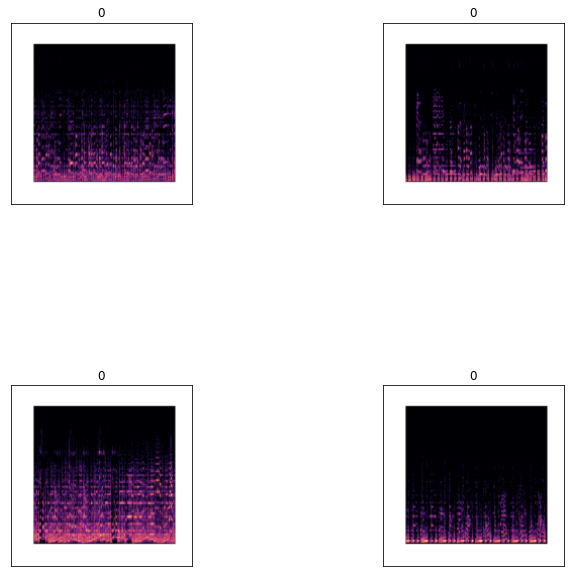

In [ ]:
data_visu =vision.datasets.ImageFolder(root = data_path, transform= transforms.Resize((180,180)))

itr=iter(data_visu)
fig=plt.figure(figsize=(10, 10))
fig.tight_layout()
plt.subplots_adjust( wspace=1, hspace=1)
for i in range(4):
            img,label=next(itr)
            t=fig.add_subplot(2,2,i+1)
            # set the title of the image equal to its label
            t.set_title(str(label))
            t.axes.get_xaxis().set_visible(False)
            t.axes.get_yaxis().set_visible(False)
            plt.imshow(img,cmap='gray_r')

## Splitting the Dataset

In [ ]:
train_data, val_data, test_data = torch.utils.data.random_split(data,[0.7,0.2,0.1])

In [ ]:

BATCH_SIZE = 32

train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
itr=iter(train_data_loader)
b,l=next(itr)
print("b has shape=",b.size())
print("l has shape=",l.size())

b has shape= torch.Size([32, 3, 180, 180])
l has shape= torch.Size([32])


In [ ]:
itr=iter(train_data_loader)
# retrieve the next (img,label) batch of pairs
imgs,labels=next(itr)
print("before flattening the shape is {}".format(imgs.size()))
input=torch.flatten(imgs,start_dim=1)
print("After flattening the shape is {}".format(input.size()))

before flattening the shape is torch.Size([32, 3, 180, 180])
After flattening the shape is torch.Size([32, 97200])


In [ ]:
#Setting up GPU
device=torch.device('cuda')

# MODELS

In [ ]:
#Function to plot training and validatioin accuracy for each epoch
def visualise_training(epoch,train_acc,val_acc):
  x = [x+1 for x in range(epoch)]

  try: 
    ta = [x.detach().cpu().numpy() for x in train_acc]
    plt.plot(x, ta, label ='Training accuracy')
  except:
    plt.plot(x, train_acc, label ='Training accuracy')

  plt.plot(x, val_acc, '-.', label ='Validation accuracy')

  plt.xlabel("X-axis data")
  plt.ylabel("Y-axis data")
  plt.legend()
  plt.title('Accuracy in each epochs')
  plt.show()

In [ ]:
def get_accuracy(dataloader,model,device):

  total=len(dataloader.dataset)
  correct=0
  
  for data in dataloader:
    imgs,labels=data
    imgs=imgs.to(device)
    labels=labels.to(device)
    outputs=model(imgs)
  # the second return value is the index of the max i.e. argmax

    _,predicted=torch.max(outputs.data,1)
    correct+=(predicted==labels).sum()
  

  return (correct/total).item()

## CLASSIFIERS USING ADAM OPTIMISER

### Feedforward Neural Network Model

In [ ]:
input_size=3*180*180
hidden_size1=128
hidden_size2=256
output_size=10

#Defining the network
class Net(nn.Module):
    def __init__(self,in_features,out_features):
        super().__init__()

        self.relu=nn.ReLU()
        self.layer1=nn.Linear(in_features,hidden_size1)
        self.layer2=nn.Linear(hidden_size1,hidden_size2)
        self.layer3=nn.Linear(hidden_size2,out_features)

    def forward(self,x):
        x=x.flatten(start_dim=1)
        x=self.layer1(x)
        x=self.relu(x)
        x=self.layer2(x)
        x=self.relu(x)
        x=self.layer3(x)

        return x

In [ ]:
# Example output
itr=iter(train_data_loader)
imgs,labels=next(itr)
model=Net(input_size,output_size)
output=model(imgs)
output.size()

torch.Size([32, 10])

In [ ]:
#Training 1st netwrok FeedForward Neural Netork
def classifier1(epochs,train_data_loader,val_data_loader):
  model=Net(input_size,output_size)

  model=model.cuda()

  # Setting the optimiser
  optimizer=optim.Adam(model.parameters(),lr=3e-4)

  #Setting loss function
  loss_fn=nn.CrossEntropyLoss()
  running_loss=0.0

  #List to store accuracy of model after each epoch
  train_acc=[]
  val_acc = []
  
  #Training the model
  for epoch in range(epochs):
      correct = 0
      for imgs,labels in train_data_loader:
          imgs=imgs.cuda()
          labels=labels.cuda()
          output=model(imgs)
          loss=loss_fn(output,labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          #Calculating Running Loss
          running_loss=0.99*running_loss+0.01*loss.item()        
          # _,predicted=torch.max(output.data,1)
          # correct+=(predicted==labels).sum()
      
      model.eval()
      #Getting model accuracy for train and validation
      train_accuracy = get_accuracy(train_data_loader,model,device) 
      val_accuracy = get_accuracy(val_data_loader,model,device)
      model.train()
      
      train_acc.append(train_accuracy)
      val_acc.append(val_accuracy)
      print("Epoch {},loss {:.4f}, Accuracy {}, ValAccuracy {}".format(epoch+1,running_loss,train_accuracy,val_accuracy))
  
  print()
  #Visualising the accuracy
  visualise_training(epochs,train_acc,val_acc)

  return model


Epoch 1,loss 0.4966, Accuracy 0.21714285016059875, ValAccuracy 0.2750000059604645
Epoch 2,loss 0.8213, Accuracy 0.2442857176065445, ValAccuracy 0.2149999886751175
Epoch 3,loss 1.0648, Accuracy 0.2514285743236542, ValAccuracy 0.2149999886751175
Epoch 4,loss 1.2498, Accuracy 0.3028571307659149, ValAccuracy 0.3149999976158142
Epoch 5,loss 1.3855, Accuracy 0.31142857670783997, ValAccuracy 0.2849999964237213
Epoch 6,loss 1.4834, Accuracy 0.4300000071525574, ValAccuracy 0.3999999761581421
Epoch 7,loss 1.5567, Accuracy 0.3442856967449188, ValAccuracy 0.29999998211860657
Epoch 8,loss 1.5867, Accuracy 0.4000000059604645, ValAccuracy 0.3649999797344208
Epoch 9,loss 1.5926, Accuracy 0.47999998927116394, ValAccuracy 0.3999999761581421
Epoch 10,loss 1.5851, Accuracy 0.44857141375541687, ValAccuracy 0.3700000047683716
Epoch 11,loss 1.5651, Accuracy 0.508571445941925, ValAccuracy 0.3999999761581421
Epoch 12,loss 1.5306, Accuracy 0.5199999809265137, ValAccuracy 0.38999998569488525
Epoch 13,loss 1.4882

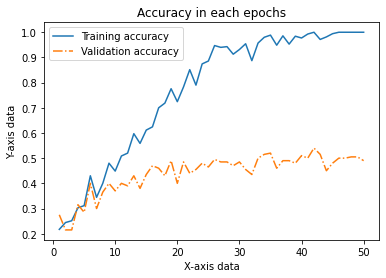

In [ ]:
# Runnning Classifier1 for 50 Epochs
model1 = classifier1(50,train_data_loader,val_data_loader)

Epoch 1,loss 0.5610, Accuracy 0.2028571367263794, ValAccuracy 0.26499998569488525
Epoch 2,loss 0.8763, Accuracy 0.2514285743236542, ValAccuracy 0.2549999952316284
Epoch 3,loss 1.1063, Accuracy 0.17000000178813934, ValAccuracy 0.20999999344348907
Epoch 4,loss 1.2774, Accuracy 0.40714284777641296, ValAccuracy 0.375
Epoch 5,loss 1.4071, Accuracy 0.33142855763435364, ValAccuracy 0.3050000071525574
Epoch 6,loss 1.4851, Accuracy 0.46714285016059875, ValAccuracy 0.38999998569488525
Epoch 7,loss 1.5366, Accuracy 0.40857142210006714, ValAccuracy 0.4350000023841858
Epoch 8,loss 1.5551, Accuracy 0.4714285731315613, ValAccuracy 0.35999998450279236
Epoch 9,loss 1.5472, Accuracy 0.5128571391105652, ValAccuracy 0.3999999761581421
Epoch 10,loss 1.5286, Accuracy 0.5642856955528259, ValAccuracy 0.42499998211860657
Epoch 11,loss 1.5028, Accuracy 0.5028571486473083, ValAccuracy 0.3999999761581421
Epoch 12,loss 1.4745, Accuracy 0.5057142972946167, ValAccuracy 0.39499998092651367
Epoch 13,loss 1.4279, Accur

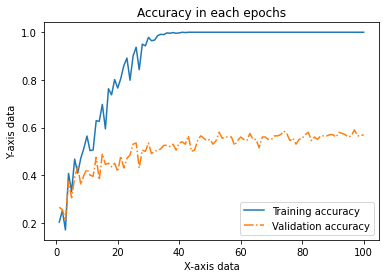

In [ ]:
#Running Classifier 1 for 100 epochs
model2 = classifier1(100,train_data_loader,val_data_loader)

In [ ]:
#Model Description
for c in model1.children():
    print(c)

ReLU()
Linear(in_features=97200, out_features=128, bias=True)
Linear(in_features=128, out_features=256, bias=True)
Linear(in_features=256, out_features=10, bias=True)


#### The training accuracy and validation accuracy for both the model are very low implying that the model is underfitting. There's also increase in difference of accuracy after 40th Epoch

### Convolution Network

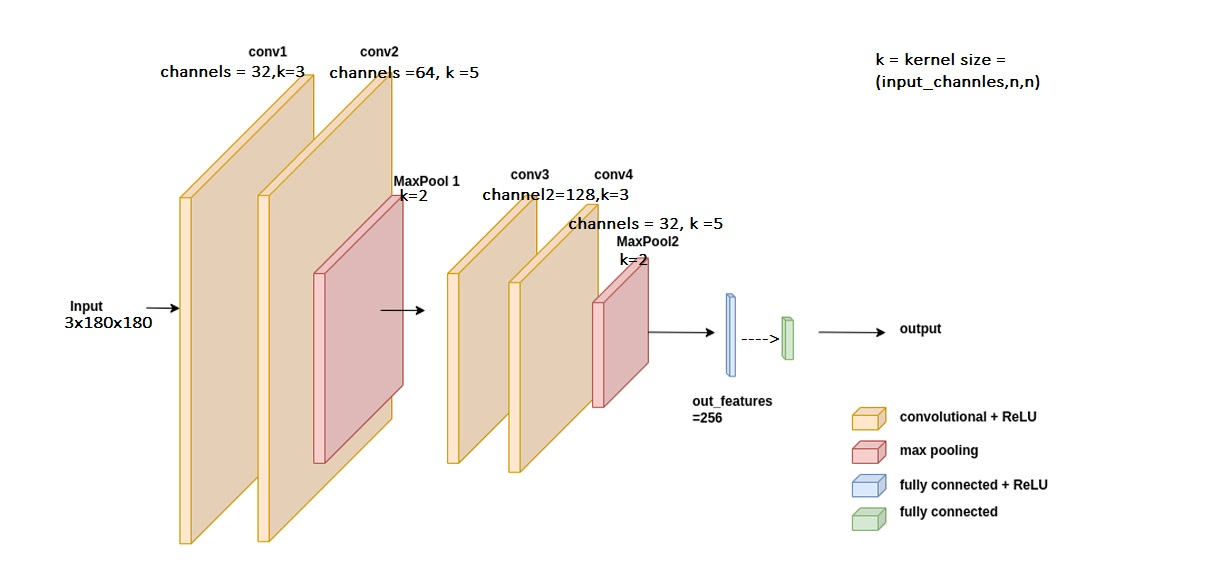

We will be using the above architecture for the convoution network

In [ ]:
#Defining the network
class Net2(nn.Module):
  def __init__(self):
    super().__init__()
    self.relu=nn.ReLU()
    self.conv1=nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3)# input  ---> (*,3,180,180) Output  ---> (*,32,178,178)
    self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5)# input  ---> (*,32,178,178) Output ---> (*,64,174,174)
    self.pool1=nn.MaxPool2d(kernel_size=(2,2)) # input  ---> (*,64,174,174) Output  ---> (*,64,87,87) 
    
    self.conv3=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3) # input ---> (*,64,87,87) Output ---> (*,128,85,85)
    self.conv4=nn.Conv2d(in_channels=128,out_channels=32,kernel_size=5) # input ---> (*,128,85,85) Output ---> (*,32,81,81)
    self.pool2=nn.MaxPool2d(kernel_size=(2,2)) # input ---> (*,32,81,81) output ---> (*,32,40,40)
    
    self.flatten=nn.Flatten() #input --->(*,32,40,40) output---> (*,51200)
    self.fc1=nn.Linear(in_features=32*40*40,out_features=256) # input ---> (*,51200) output ---> (*,256)
    self.fc2=nn.Linear(in_features=256,out_features=10) #input ---> (*,256) output ---> (*,10)

  def forward(self,x):
    x=self.conv1(x)
    x=self.relu(x)
    x=self.conv2(x)
    x=self.relu(x)
    x=self.pool1(x)
    
    x=self.conv3(x)
    x=self.relu(x)
    x=self.conv4(x)
    x=self.relu(x)
    x=self.pool2(x)
    
    x=self.flatten(x)
    x=self.fc1(x)
    x=self.relu(x)
    x=self.fc2(x)
    return x

In [ ]:
#Training 2nd network i.e Convolution Neural Netork
def classifier2(epochs,train_data_loader,val_data_loader):
  
  model=Net2().to(device)
  optimizer=Adam(model.parameters())
  loss_fn=nn.CrossEntropyLoss()

  train_acc=[]
  val_acc = []

  for epoch in range(epochs):
      loop=tqdm(train_data_loader)
      loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
      epoch_loss=0.
      for (imgs,labels) in loop:
          optimizer.zero_grad()
          imgs=imgs.to(device)
          labels=labels.to(device)
          outputs=model(imgs)
          loss=loss_fn(outputs,labels)
          loss.backward()
          optimizer.step()
          epoch_loss=0.9*epoch_loss+0.1*loss.item()
          loop.set_postfix(loss=epoch_loss)

      model.eval()
      t_acc=get_accuracy(train_data_loader,model,device) 
      v_acc=get_accuracy(val_data_loader,model,device)
      train_acc.append(t_acc)
      val_acc.append(v_acc)
      model.train()

      print("Epoch {},loss {:.4f}, Accuracy {}, ValAccuracy {}".format(epoch+1,epoch_loss,t_acc,v_acc))
      
  #     writer.add_scalar("loss",epoch_loss,epoch)
  #     writer.add_scalars("acc",{'train':t_acc,'valid':v_acc},epoch)
  # writer.close()   
  
  visualise_training(epochs,train_acc,val_acc)

  return model

Epoch [1/50]: 100%|██████████| 22/22 [00:05<00:00,  3.78it/s, loss=2.09]


Epoch 1,loss 2.0932, Accuracy 0.1014285683631897, ValAccuracy 0.10499999672174454


Epoch [2/50]: 100%|██████████| 22/22 [00:06<00:00,  3.53it/s, loss=2.08]


Epoch 2,loss 2.0760, Accuracy 0.1014285683631897, ValAccuracy 0.10499999672174454


Epoch [3/50]: 100%|██████████| 22/22 [00:05<00:00,  4.09it/s, loss=2.08]


Epoch 3,loss 2.0761, Accuracy 0.1014285683631897, ValAccuracy 0.10499999672174454


Epoch [4/50]: 100%|██████████| 22/22 [00:05<00:00,  4.19it/s, loss=2.08]


Epoch 4,loss 2.0758, Accuracy 0.1014285683631897, ValAccuracy 0.10499999672174454


Epoch [5/50]: 100%|██████████| 22/22 [00:05<00:00,  4.16it/s, loss=2.08]


Epoch 5,loss 2.0769, Accuracy 0.1014285683631897, ValAccuracy 0.10499999672174454


Epoch [6/50]: 100%|██████████| 22/22 [00:06<00:00,  3.45it/s, loss=2.08]


Epoch 6,loss 2.0758, Accuracy 0.1014285683631897, ValAccuracy 0.10499999672174454


Epoch [7/50]: 100%|██████████| 22/22 [00:05<00:00,  3.87it/s, loss=2.08]


Epoch 7,loss 2.0764, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [8/50]: 100%|██████████| 22/22 [00:05<00:00,  4.12it/s, loss=2.08]


Epoch 8,loss 2.0757, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [9/50]: 100%|██████████| 22/22 [00:05<00:00,  4.11it/s, loss=2.08]


Epoch 9,loss 2.0751, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [10/50]: 100%|██████████| 22/22 [00:05<00:00,  3.87it/s, loss=2.08]


Epoch 10,loss 2.0763, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [11/50]: 100%|██████████| 22/22 [00:06<00:00,  3.47it/s, loss=2.08]


Epoch 11,loss 2.0765, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [12/50]: 100%|██████████| 22/22 [00:05<00:00,  3.74it/s, loss=2.07]


Epoch 12,loss 2.0746, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [13/50]: 100%|██████████| 22/22 [00:05<00:00,  3.73it/s, loss=2.08]


Epoch 13,loss 2.0760, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [14/50]: 100%|██████████| 22/22 [00:05<00:00,  4.12it/s, loss=2.08]


Epoch 14,loss 2.0750, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [15/50]: 100%|██████████| 22/22 [00:05<00:00,  4.17it/s, loss=2.08]


Epoch 15,loss 2.0758, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [16/50]: 100%|██████████| 22/22 [00:05<00:00,  3.75it/s, loss=2.08]


Epoch 16,loss 2.0755, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [17/50]: 100%|██████████| 22/22 [00:06<00:00,  3.55it/s, loss=2.08]


Epoch 17,loss 2.0756, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [18/50]: 100%|██████████| 22/22 [00:05<00:00,  4.08it/s, loss=2.07]


Epoch 18,loss 2.0743, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [19/50]: 100%|██████████| 22/22 [00:05<00:00,  4.20it/s, loss=2.08]


Epoch 19,loss 2.0757, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [20/50]: 100%|██████████| 22/22 [00:05<00:00,  4.20it/s, loss=2.08]


Epoch 20,loss 2.0761, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [21/50]: 100%|██████████| 22/22 [00:06<00:00,  3.45it/s, loss=2.08]


Epoch 21,loss 2.0754, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [22/50]: 100%|██████████| 22/22 [00:05<00:00,  3.99it/s, loss=2.08]


Epoch 22,loss 2.0762, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [23/50]: 100%|██████████| 22/22 [00:05<00:00,  4.15it/s, loss=2.08]


Epoch 23,loss 2.0750, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [24/50]: 100%|██████████| 22/22 [00:05<00:00,  4.14it/s, loss=2.08]


Epoch 24,loss 2.0763, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [25/50]: 100%|██████████| 22/22 [00:05<00:00,  3.75it/s, loss=2.07]


Epoch 25,loss 2.0744, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [26/50]: 100%|██████████| 22/22 [00:06<00:00,  3.19it/s, loss=2.08]


Epoch 26,loss 2.0773, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [27/50]: 100%|██████████| 22/22 [00:06<00:00,  3.29it/s, loss=2.08]


Epoch 27,loss 2.0763, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [28/50]: 100%|██████████| 22/22 [00:05<00:00,  4.13it/s, loss=2.07]


Epoch 28,loss 2.0748, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [29/50]: 100%|██████████| 22/22 [00:05<00:00,  4.10it/s, loss=2.08]


Epoch 29,loss 2.0767, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [30/50]: 100%|██████████| 22/22 [00:05<00:00,  4.22it/s, loss=2.08]


Epoch 30,loss 2.0754, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [31/50]: 100%|██████████| 22/22 [00:06<00:00,  3.56it/s, loss=2.08]


Epoch 31,loss 2.0756, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [32/50]: 100%|██████████| 22/22 [00:05<00:00,  3.85it/s, loss=2.08]


Epoch 32,loss 2.0750, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [33/50]: 100%|██████████| 22/22 [00:05<00:00,  4.11it/s, loss=2.07]


Epoch 33,loss 2.0745, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [34/50]: 100%|██████████| 22/22 [00:05<00:00,  4.15it/s, loss=2.08]


Epoch 34,loss 2.0772, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [35/50]: 100%|██████████| 22/22 [00:05<00:00,  3.96it/s, loss=2.08]


Epoch 35,loss 2.0760, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [36/50]: 100%|██████████| 22/22 [00:06<00:00,  3.30it/s, loss=2.07]


Epoch 36,loss 2.0739, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [37/50]: 100%|██████████| 22/22 [00:05<00:00,  3.92it/s, loss=2.08]


Epoch 37,loss 2.0767, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [38/50]: 100%|██████████| 22/22 [00:05<00:00,  4.13it/s, loss=2.08]


Epoch 38,loss 2.0753, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [39/50]: 100%|██████████| 22/22 [00:05<00:00,  4.13it/s, loss=2.08]


Epoch 39,loss 2.0754, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [40/50]: 100%|██████████| 22/22 [00:05<00:00,  3.76it/s, loss=2.07]


Epoch 40,loss 2.0739, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [41/50]: 100%|██████████| 22/22 [00:06<00:00,  3.49it/s, loss=2.08]


Epoch 41,loss 2.0758, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [42/50]: 100%|██████████| 22/22 [00:05<00:00,  3.95it/s, loss=2.07]


Epoch 42,loss 2.0749, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [43/50]: 100%|██████████| 22/22 [00:05<00:00,  3.71it/s, loss=2.08]


Epoch 43,loss 2.0750, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [44/50]: 100%|██████████| 22/22 [00:05<00:00,  3.78it/s, loss=2.08]


Epoch 44,loss 2.0755, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [45/50]: 100%|██████████| 22/22 [00:05<00:00,  3.72it/s, loss=2.08]


Epoch 45,loss 2.0751, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [46/50]: 100%|██████████| 22/22 [00:06<00:00,  3.39it/s, loss=2.08]


Epoch 46,loss 2.0762, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [47/50]: 100%|██████████| 22/22 [00:05<00:00,  4.05it/s, loss=2.07]


Epoch 47,loss 2.0748, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [48/50]: 100%|██████████| 22/22 [00:05<00:00,  4.02it/s, loss=2.08]


Epoch 48,loss 2.0750, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [49/50]: 100%|██████████| 22/22 [00:05<00:00,  4.03it/s, loss=2.08]


Epoch 49,loss 2.0753, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [50/50]: 100%|██████████| 22/22 [00:05<00:00,  3.95it/s, loss=2.07]


Epoch 50,loss 2.0747, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


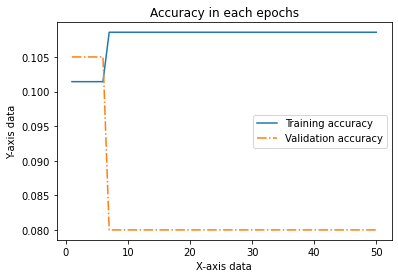

In [ ]:
model3 = classifier2(50,train_data_loader,val_data_loader)

Epoch [1/100]: 100%|██████████| 22/22 [00:07<00:00,  2.81it/s, loss=2.08]


Epoch 1,loss 2.0829, Accuracy 0.09428571164608002, ValAccuracy 0.14499999582767487


Epoch [2/100]: 100%|██████████| 22/22 [00:06<00:00,  3.38it/s, loss=2.08]


Epoch 2,loss 2.0763, Accuracy 0.09428571164608002, ValAccuracy 0.14499999582767487


Epoch [3/100]: 100%|██████████| 22/22 [00:05<00:00,  4.02it/s, loss=2.08]


Epoch 3,loss 2.0770, Accuracy 0.09428571164608002, ValAccuracy 0.14499999582767487


Epoch [4/100]: 100%|██████████| 22/22 [00:05<00:00,  4.12it/s, loss=2.08]


Epoch 4,loss 2.0762, Accuracy 0.1014285683631897, ValAccuracy 0.08999999612569809


Epoch [5/100]: 100%|██████████| 22/22 [00:05<00:00,  4.13it/s, loss=2.08]


Epoch 5,loss 2.0773, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [6/100]: 100%|██████████| 22/22 [00:05<00:00,  3.71it/s, loss=2.08]


Epoch 6,loss 2.0761, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [7/100]: 100%|██████████| 22/22 [00:06<00:00,  3.21it/s, loss=2.08]


Epoch 7,loss 2.0760, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [8/100]: 100%|██████████| 22/22 [00:06<00:00,  3.18it/s, loss=2.08]


Epoch 8,loss 2.0766, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [9/100]: 100%|██████████| 22/22 [00:05<00:00,  3.86it/s, loss=2.08]


Epoch 9,loss 2.0750, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [10/100]: 100%|██████████| 22/22 [00:05<00:00,  4.09it/s, loss=2.08]


Epoch 10,loss 2.0757, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [11/100]: 100%|██████████| 22/22 [00:05<00:00,  4.04it/s, loss=2.08]


Epoch 11,loss 2.0751, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [12/100]: 100%|██████████| 22/22 [00:05<00:00,  4.09it/s, loss=2.08]


Epoch 12,loss 2.0752, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [13/100]: 100%|██████████| 22/22 [00:06<00:00,  3.51it/s, loss=2.08]


Epoch 13,loss 2.0767, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [14/100]: 100%|██████████| 22/22 [00:05<00:00,  3.69it/s, loss=2.08]


Epoch 14,loss 2.0756, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [15/100]: 100%|██████████| 22/22 [00:05<00:00,  4.09it/s, loss=2.07]


Epoch 15,loss 2.0747, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [16/100]: 100%|██████████| 22/22 [00:05<00:00,  4.10it/s, loss=2.08]


Epoch 16,loss 2.0751, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [17/100]: 100%|██████████| 22/22 [00:05<00:00,  4.06it/s, loss=2.07]


Epoch 17,loss 2.0742, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [18/100]: 100%|██████████| 22/22 [00:06<00:00,  3.55it/s, loss=2.08]


Epoch 18,loss 2.0751, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [19/100]: 100%|██████████| 22/22 [00:06<00:00,  3.24it/s, loss=2.07]


Epoch 19,loss 2.0745, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [20/100]: 100%|██████████| 22/22 [00:05<00:00,  3.92it/s, loss=2.08]


Epoch 20,loss 2.0756, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [21/100]: 100%|██████████| 22/22 [00:05<00:00,  4.05it/s, loss=2.07]


Epoch 21,loss 2.0749, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [22/100]: 100%|██████████| 22/22 [00:05<00:00,  4.05it/s, loss=2.08]


Epoch 22,loss 2.0752, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [23/100]: 100%|██████████| 22/22 [00:06<00:00,  3.42it/s, loss=2.08]


Epoch 23,loss 2.0753, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [24/100]: 100%|██████████| 22/22 [00:05<00:00,  3.81it/s, loss=2.08]


Epoch 24,loss 2.0762, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [25/100]: 100%|██████████| 22/22 [00:06<00:00,  3.37it/s, loss=2.08]


Epoch 25,loss 2.0756, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [26/100]: 100%|██████████| 22/22 [00:05<00:00,  3.90it/s, loss=2.08]


Epoch 26,loss 2.0770, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [27/100]: 100%|██████████| 22/22 [00:05<00:00,  4.08it/s, loss=2.08]


Epoch 27,loss 2.0761, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [28/100]: 100%|██████████| 22/22 [00:05<00:00,  4.12it/s, loss=2.07]


Epoch 28,loss 2.0746, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [29/100]: 100%|██████████| 22/22 [00:05<00:00,  3.72it/s, loss=2.08]


Epoch 29,loss 2.0757, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [30/100]: 100%|██████████| 22/22 [00:06<00:00,  3.38it/s, loss=2.08]


Epoch 30,loss 2.0759, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [31/100]: 100%|██████████| 22/22 [00:05<00:00,  4.00it/s, loss=2.08]


Epoch 31,loss 2.0760, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [32/100]: 100%|██████████| 22/22 [00:05<00:00,  4.12it/s, loss=2.08]


Epoch 32,loss 2.0755, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [33/100]: 100%|██████████| 22/22 [00:05<00:00,  4.15it/s, loss=2.08]


Epoch 33,loss 2.0769, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [34/100]: 100%|██████████| 22/22 [00:05<00:00,  3.74it/s, loss=2.08]


Epoch 34,loss 2.0762, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [35/100]: 100%|██████████| 22/22 [00:06<00:00,  3.46it/s, loss=2.07]


Epoch 35,loss 2.0745, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [36/100]: 100%|██████████| 22/22 [00:05<00:00,  4.01it/s, loss=2.08]


Epoch 36,loss 2.0766, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [37/100]: 100%|██████████| 22/22 [00:05<00:00,  4.05it/s, loss=2.08]


Epoch 37,loss 2.0760, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [38/100]: 100%|██████████| 22/22 [00:05<00:00,  4.04it/s, loss=2.08]


Epoch 38,loss 2.0758, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [39/100]: 100%|██████████| 22/22 [00:07<00:00,  3.05it/s, loss=2.07]


Epoch 39,loss 2.0735, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [40/100]: 100%|██████████| 22/22 [00:06<00:00,  3.46it/s, loss=2.07]


Epoch 40,loss 2.0744, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [41/100]: 100%|██████████| 22/22 [00:05<00:00,  4.06it/s, loss=2.07]


Epoch 41,loss 2.0735, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [42/100]: 100%|██████████| 22/22 [00:05<00:00,  4.06it/s, loss=2.08]


Epoch 42,loss 2.0753, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [43/100]: 100%|██████████| 22/22 [00:05<00:00,  4.13it/s, loss=2.07]


Epoch 43,loss 2.0739, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [44/100]: 100%|██████████| 22/22 [00:05<00:00,  3.74it/s, loss=2.08]


Epoch 44,loss 2.0759, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [45/100]: 100%|██████████| 22/22 [00:06<00:00,  3.39it/s, loss=2.08]


Epoch 45,loss 2.0770, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [46/100]: 100%|██████████| 22/22 [00:05<00:00,  4.02it/s, loss=2.07]


Epoch 46,loss 2.0748, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [47/100]: 100%|██████████| 22/22 [00:05<00:00,  4.09it/s, loss=2.08]


Epoch 47,loss 2.0755, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [48/100]: 100%|██████████| 22/22 [00:05<00:00,  4.10it/s, loss=2.08]


Epoch 48,loss 2.0758, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [49/100]: 100%|██████████| 22/22 [00:05<00:00,  3.80it/s, loss=2.07]


Epoch 49,loss 2.0746, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [50/100]: 100%|██████████| 22/22 [00:06<00:00,  3.31it/s, loss=2.07]


Epoch 50,loss 2.0746, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [51/100]: 100%|██████████| 22/22 [00:05<00:00,  3.96it/s, loss=2.07]


Epoch 51,loss 2.0750, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [52/100]: 100%|██████████| 22/22 [00:05<00:00,  4.04it/s, loss=2.08]


Epoch 52,loss 2.0769, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [53/100]: 100%|██████████| 22/22 [00:05<00:00,  4.10it/s, loss=2.07]


Epoch 53,loss 2.0748, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [54/100]: 100%|██████████| 22/22 [00:05<00:00,  3.95it/s, loss=2.07]


Epoch 54,loss 2.0743, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [55/100]: 100%|██████████| 22/22 [00:07<00:00,  2.82it/s, loss=2.08]


Epoch 55,loss 2.0762, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [56/100]: 100%|██████████| 22/22 [00:05<00:00,  4.14it/s, loss=2.07]


Epoch 56,loss 2.0745, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [57/100]: 100%|██████████| 22/22 [00:05<00:00,  4.12it/s, loss=2.08]


Epoch 57,loss 2.0756, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [58/100]: 100%|██████████| 22/22 [00:05<00:00,  4.14it/s, loss=2.08]


Epoch 58,loss 2.0763, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [59/100]: 100%|██████████| 22/22 [00:06<00:00,  3.32it/s, loss=2.07]


Epoch 59,loss 2.0736, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [60/100]: 100%|██████████| 22/22 [00:05<00:00,  3.71it/s, loss=2.08]


Epoch 60,loss 2.0758, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [61/100]: 100%|██████████| 22/22 [00:05<00:00,  4.07it/s, loss=2.07]


Epoch 61,loss 2.0739, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [62/100]: 100%|██████████| 22/22 [00:05<00:00,  4.08it/s, loss=2.08]


Epoch 62,loss 2.0759, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [63/100]: 100%|██████████| 22/22 [00:05<00:00,  4.14it/s, loss=2.07]


Epoch 63,loss 2.0743, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [64/100]: 100%|██████████| 22/22 [00:06<00:00,  3.32it/s, loss=2.08]


Epoch 64,loss 2.0754, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [65/100]: 100%|██████████| 22/22 [00:05<00:00,  3.71it/s, loss=2.07]


Epoch 65,loss 2.0747, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [66/100]: 100%|██████████| 22/22 [00:05<00:00,  4.10it/s, loss=2.07]


Epoch 66,loss 2.0739, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [67/100]: 100%|██████████| 22/22 [00:05<00:00,  4.12it/s, loss=2.08]


Epoch 67,loss 2.0754, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [68/100]: 100%|██████████| 22/22 [00:05<00:00,  3.97it/s, loss=2.08]


Epoch 68,loss 2.0769, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [69/100]: 100%|██████████| 22/22 [00:06<00:00,  3.22it/s, loss=2.08]


Epoch 69,loss 2.0761, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [70/100]: 100%|██████████| 22/22 [00:05<00:00,  3.91it/s, loss=2.07]


Epoch 70,loss 2.0749, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [71/100]: 100%|██████████| 22/22 [00:06<00:00,  3.54it/s, loss=2.07]


Epoch 71,loss 2.0749, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [72/100]: 100%|██████████| 22/22 [00:05<00:00,  4.17it/s, loss=2.08]


Epoch 72,loss 2.0768, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [73/100]: 100%|██████████| 22/22 [00:05<00:00,  4.07it/s, loss=2.07]


Epoch 73,loss 2.0736, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [74/100]: 100%|██████████| 22/22 [00:06<00:00,  3.45it/s, loss=2.08]


Epoch 74,loss 2.0753, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [75/100]: 100%|██████████| 22/22 [00:06<00:00,  3.47it/s, loss=2.08]


Epoch 75,loss 2.0776, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [76/100]: 100%|██████████| 22/22 [00:05<00:00,  4.03it/s, loss=2.07]


Epoch 76,loss 2.0730, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [77/100]: 100%|██████████| 22/22 [00:05<00:00,  4.02it/s, loss=2.08]


Epoch 77,loss 2.0756, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [78/100]: 100%|██████████| 22/22 [00:05<00:00,  4.12it/s, loss=2.07]


Epoch 78,loss 2.0748, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [79/100]: 100%|██████████| 22/22 [00:06<00:00,  3.63it/s, loss=2.08]


Epoch 79,loss 2.0755, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [80/100]: 100%|██████████| 22/22 [00:06<00:00,  3.45it/s, loss=2.08]


Epoch 80,loss 2.0765, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [81/100]: 100%|██████████| 22/22 [00:05<00:00,  4.02it/s, loss=2.08]


Epoch 81,loss 2.0758, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [82/100]: 100%|██████████| 22/22 [00:05<00:00,  4.09it/s, loss=2.07]


Epoch 82,loss 2.0747, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [83/100]: 100%|██████████| 22/22 [00:05<00:00,  4.03it/s, loss=2.08]


Epoch 83,loss 2.0754, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [84/100]: 100%|██████████| 22/22 [00:06<00:00,  3.64it/s, loss=2.08]


Epoch 84,loss 2.0753, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [85/100]: 100%|██████████| 22/22 [00:06<00:00,  3.31it/s, loss=2.08]


Epoch 85,loss 2.0751, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [86/100]: 100%|██████████| 22/22 [00:05<00:00,  3.99it/s, loss=2.08]


Epoch 86,loss 2.0754, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [87/100]: 100%|██████████| 22/22 [00:05<00:00,  4.09it/s, loss=2.08]


Epoch 87,loss 2.0753, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [88/100]: 100%|██████████| 22/22 [00:05<00:00,  4.07it/s, loss=2.08]


Epoch 88,loss 2.0753, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [89/100]: 100%|██████████| 22/22 [00:05<00:00,  4.03it/s, loss=2.08]


Epoch 89,loss 2.0759, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [90/100]: 100%|██████████| 22/22 [00:06<00:00,  3.62it/s, loss=2.07]


Epoch 90,loss 2.0744, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [91/100]: 100%|██████████| 22/22 [00:06<00:00,  3.27it/s, loss=2.08]


Epoch 91,loss 2.0754, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [92/100]: 100%|██████████| 22/22 [00:05<00:00,  4.02it/s, loss=2.08]


Epoch 92,loss 2.0750, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [93/100]: 100%|██████████| 22/22 [00:05<00:00,  4.09it/s, loss=2.07]


Epoch 93,loss 2.0740, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [94/100]: 100%|██████████| 22/22 [00:05<00:00,  4.06it/s, loss=2.08]


Epoch 94,loss 2.0752, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [95/100]: 100%|██████████| 22/22 [00:06<00:00,  3.62it/s, loss=2.08]


Epoch 95,loss 2.0771, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [96/100]: 100%|██████████| 22/22 [00:06<00:00,  3.33it/s, loss=2.07]


Epoch 96,loss 2.0739, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [97/100]: 100%|██████████| 22/22 [00:05<00:00,  4.04it/s, loss=2.07]


Epoch 97,loss 2.0749, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [98/100]: 100%|██████████| 22/22 [00:05<00:00,  4.12it/s, loss=2.07]


Epoch 98,loss 2.0737, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [99/100]: 100%|██████████| 22/22 [00:05<00:00,  4.12it/s, loss=2.07]


Epoch 99,loss 2.0744, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [100/100]: 100%|██████████| 22/22 [00:06<00:00,  3.61it/s, loss=2.08]


Epoch 100,loss 2.0756, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


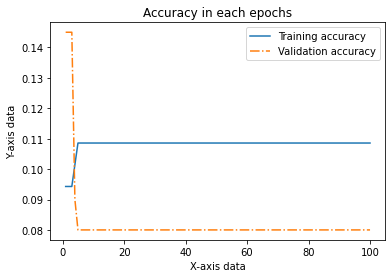

In [ ]:
model4 = classifier2(100,train_data_loader,val_data_loader)

In [ ]:
#Model Description
for c in model3.children():
    print(c)

ReLU()
Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
Conv2d(128, 32, kernel_size=(5, 5), stride=(1, 1))
MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
Flatten(start_dim=1, end_dim=-1)
Linear(in_features=51200, out_features=256, bias=True)
Linear(in_features=256, out_features=10, bias=True)


### Adding Batch Normalisation to the above Convolution Network

In [ ]:
#Defining the network
class Net3(nn.Module):
  def __init__(self):
    super().__init__()
    self.relu=nn.ReLU()
    self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3)# input  ---> (*,3,180,180) Output  ---> (*,32,178,178)
    self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5)# input  ---> (*,32,178,178) Output ---> (*,64,174,174)
    self.pool1 = nn.MaxPool2d(kernel_size=(2,2)) # input  ---> (*,64,174,174) Output  ---> (*,64,87,87) 
    
    self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3) # input ---> (*,64,87,87) Output ---> (*,128,85,85)
    self.conv4 = nn.Conv2d(in_channels=128,out_channels=32,kernel_size=5) # input ---> (*,128,85,85) Output ---> (*,32,81,81)
    self.pool2 = nn.MaxPool2d(kernel_size=(2,2)) # input ---> (*,32,81,81) output ---> (*,32,40,40)
    
    self.flatten = nn.Flatten() #input --->(*,32,40,40) output---> (*,51200)
    self.fc1 = nn.Linear(in_features=32*40*40,out_features=256) # input ---> (*,51200) output ---> (*,256)
    self.fc2 = nn.Linear(in_features=256,out_features=10) #input ---> (*,256) output ---> (*,10)

    self.batchnorm1 = nn.BatchNorm2d(32)
    self.batchnorm2 = nn.BatchNorm2d(64)
    self.batchnorm3 = nn.BatchNorm2d(128)
    self.batchnorm4 = nn.BatchNorm2d(32)

  def forward(self,x):
    x=self.conv1(x)
    x=self.relu(x)
    x= self.batchnorm1(x)
    x=self.conv2(x)
    x=self.relu(x)
    x= self.batchnorm2(x)
    x=self.pool1(x)
    
    x=self.conv3(x)
    x=self.relu(x)
    x= self.batchnorm3(x)
    x=self.conv4(x)
    x=self.relu(x)
    x= self.batchnorm4(x)
    x=self.pool2(x)
    
    x=self.flatten(x)
    x=self.fc1(x)
    x=self.relu(x)
    x=self.fc2(x)
    return x

In [ ]:
#Training 3rd network i.e Convolution Neural Netork of above arhitecture with Batch Normalistion layers
def classifier3(epochs,train_data_loader,val_data_loader):

  model=Net3().to(device)
  optimizer=Adam(model.parameters())
  loss_fn=nn.CrossEntropyLoss()

  train_acc=[]
  val_acc = []

  for epoch in range(epochs):
      loop=tqdm(train_data_loader)
      loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
      epoch_loss=0.
      for (imgs,labels) in loop:
          optimizer.zero_grad()
          imgs=imgs.to(device)
          labels=labels.to(device)
          outputs=model(imgs)
          loss=loss_fn(outputs,labels)
          loss.backward()
          optimizer.step()
          epoch_loss=0.9*epoch_loss+0.1*loss.item()
          loop.set_postfix(loss=epoch_loss)

      model.eval()
      t_acc=get_accuracy(train_data_loader,model,device) 
      v_acc=get_accuracy(val_data_loader,model,device)
      train_acc.append(t_acc)
      val_acc.append(v_acc)
      model.train()

      print("Epoch {},loss {:.4f}, Accuracy {}, ValAccuracy {}".format(epoch+1,epoch_loss,t_acc,v_acc))
      
  
  visualise_training(epochs,train_acc,val_acc)

  return model

Epoch [1/50]: 100%|██████████| 22/22 [00:07<00:00,  3.05it/s, loss=5.08]


Epoch 1,loss 5.0839, Accuracy 0.09428571164608002, ValAccuracy 0.14499999582767487


Epoch [2/50]: 100%|██████████| 22/22 [00:06<00:00,  3.53it/s, loss=1.83]


Epoch 2,loss 1.8253, Accuracy 0.23571428656578064, ValAccuracy 0.2549999952316284


Epoch [3/50]: 100%|██████████| 22/22 [00:05<00:00,  3.72it/s, loss=1.6]


Epoch 3,loss 1.5990, Accuracy 0.36142855882644653, ValAccuracy 0.3050000071525574


Epoch [4/50]: 100%|██████████| 22/22 [00:06<00:00,  3.66it/s, loss=1.45]


Epoch 4,loss 1.4495, Accuracy 0.3871428668498993, ValAccuracy 0.4050000011920929


Epoch [5/50]: 100%|██████████| 22/22 [00:05<00:00,  3.70it/s, loss=1.37]


Epoch 5,loss 1.3679, Accuracy 0.46714285016059875, ValAccuracy 0.4699999988079071


Epoch [6/50]: 100%|██████████| 22/22 [00:06<00:00,  3.37it/s, loss=1.23]


Epoch 6,loss 1.2313, Accuracy 0.5371428728103638, ValAccuracy 0.4899999797344208


Epoch [7/50]: 100%|██████████| 22/22 [00:06<00:00,  3.39it/s, loss=1.16]


Epoch 7,loss 1.1596, Accuracy 0.4300000071525574, ValAccuracy 0.3349999785423279


Epoch [8/50]: 100%|██████████| 22/22 [00:06<00:00,  3.61it/s, loss=0.958]


Epoch 8,loss 0.9581, Accuracy 0.604285717010498, ValAccuracy 0.5699999928474426


Epoch [9/50]: 100%|██████████| 22/22 [00:05<00:00,  3.70it/s, loss=0.836]


Epoch 9,loss 0.8362, Accuracy 0.654285728931427, ValAccuracy 0.5249999761581421


Epoch [10/50]: 100%|██████████| 22/22 [00:05<00:00,  3.69it/s, loss=0.715]


Epoch 10,loss 0.7155, Accuracy 0.7199999690055847, ValAccuracy 0.5799999833106995


Epoch [11/50]: 100%|██████████| 22/22 [00:05<00:00,  3.69it/s, loss=0.664]


Epoch 11,loss 0.6636, Accuracy 0.7057142853736877, ValAccuracy 0.5099999904632568


Epoch [12/50]: 100%|██████████| 22/22 [00:06<00:00,  3.37it/s, loss=0.681]


Epoch 12,loss 0.6814, Accuracy 0.7157142758369446, ValAccuracy 0.5799999833106995


Epoch [13/50]: 100%|██████████| 22/22 [00:06<00:00,  3.21it/s, loss=0.567]


Epoch 13,loss 0.5672, Accuracy 0.7314285635948181, ValAccuracy 0.574999988079071


Epoch [14/50]: 100%|██████████| 22/22 [00:06<00:00,  3.54it/s, loss=0.42]


Epoch 14,loss 0.4195, Accuracy 0.8657142519950867, ValAccuracy 0.6049999594688416


Epoch [15/50]: 100%|██████████| 22/22 [00:06<00:00,  3.67it/s, loss=0.416]


Epoch 15,loss 0.4157, Accuracy 0.8071428537368774, ValAccuracy 0.5349999666213989


Epoch [16/50]: 100%|██████████| 22/22 [00:05<00:00,  3.69it/s, loss=0.353]


Epoch 16,loss 0.3532, Accuracy 0.8871428370475769, ValAccuracy 0.6200000047683716


Epoch [17/50]: 100%|██████████| 22/22 [00:06<00:00,  3.63it/s, loss=0.241]


Epoch 17,loss 0.2407, Accuracy 0.9628571271896362, ValAccuracy 0.6549999713897705


Epoch [18/50]: 100%|██████████| 22/22 [00:07<00:00,  2.98it/s, loss=0.204]


Epoch 18,loss 0.2037, Accuracy 0.9028571248054504, ValAccuracy 0.5899999737739563


Epoch [19/50]: 100%|██████████| 22/22 [00:06<00:00,  3.38it/s, loss=0.162]


Epoch 19,loss 0.1623, Accuracy 0.9285714030265808, ValAccuracy 0.550000011920929


Epoch [20/50]: 100%|██████████| 22/22 [00:06<00:00,  3.64it/s, loss=0.226]


Epoch 20,loss 0.2256, Accuracy 0.8985714316368103, ValAccuracy 0.5799999833106995


Epoch [21/50]: 100%|██████████| 22/22 [00:06<00:00,  3.65it/s, loss=0.198]


Epoch 21,loss 0.1982, Accuracy 0.9814285635948181, ValAccuracy 0.625


Epoch [22/50]: 100%|██████████| 22/22 [00:05<00:00,  3.68it/s, loss=0.108]


Epoch 22,loss 0.1076, Accuracy 0.9928571581840515, ValAccuracy 0.6100000143051147


Epoch [23/50]: 100%|██████████| 22/22 [00:06<00:00,  3.57it/s, loss=0.0579]


Epoch 23,loss 0.0579, Accuracy 0.9871428608894348, ValAccuracy 0.625


Epoch [24/50]: 100%|██████████| 22/22 [00:06<00:00,  3.22it/s, loss=0.041]


Epoch 24,loss 0.0410, Accuracy 0.9957142472267151, ValAccuracy 0.5799999833106995


Epoch [25/50]: 100%|██████████| 22/22 [00:06<00:00,  3.44it/s, loss=0.0339]


Epoch 25,loss 0.0339, Accuracy 0.9985713958740234, ValAccuracy 0.6699999570846558


Epoch [26/50]: 100%|██████████| 22/22 [00:06<00:00,  3.58it/s, loss=0.0236]


Epoch 26,loss 0.0236, Accuracy 0.9985713958740234, ValAccuracy 0.6399999856948853


Epoch [27/50]: 100%|██████████| 22/22 [00:06<00:00,  3.66it/s, loss=0.0215]


Epoch 27,loss 0.0215, Accuracy 0.9985713958740234, ValAccuracy 0.6499999761581421


Epoch [28/50]: 100%|██████████| 22/22 [00:05<00:00,  3.68it/s, loss=0.0117]


Epoch 28,loss 0.0117, Accuracy 0.9985713958740234, ValAccuracy 0.6499999761581421


Epoch [29/50]: 100%|██████████| 22/22 [00:06<00:00,  3.63it/s, loss=0.0147]


Epoch 29,loss 0.0147, Accuracy 0.9957142472267151, ValAccuracy 0.6449999809265137


Epoch [30/50]: 100%|██████████| 22/22 [00:06<00:00,  3.20it/s, loss=0.0124]


Epoch 30,loss 0.0124, Accuracy 0.9985713958740234, ValAccuracy 0.6049999594688416


Epoch [31/50]: 100%|██████████| 22/22 [00:06<00:00,  3.28it/s, loss=0.0103]


Epoch 31,loss 0.0103, Accuracy 1.0, ValAccuracy 0.6449999809265137


Epoch [32/50]: 100%|██████████| 22/22 [00:06<00:00,  3.59it/s, loss=0.00761]


Epoch 32,loss 0.0076, Accuracy 1.0, ValAccuracy 0.6649999618530273


Epoch [33/50]: 100%|██████████| 22/22 [00:06<00:00,  3.43it/s, loss=0.00796]


Epoch 33,loss 0.0080, Accuracy 1.0, ValAccuracy 0.625


Epoch [34/50]: 100%|██████████| 22/22 [00:05<00:00,  3.69it/s, loss=0.00444]


Epoch 34,loss 0.0044, Accuracy 1.0, ValAccuracy 0.6549999713897705


Epoch [35/50]: 100%|██████████| 22/22 [00:05<00:00,  3.68it/s, loss=0.00513]


Epoch 35,loss 0.0051, Accuracy 1.0, ValAccuracy 0.6399999856948853


Epoch [36/50]: 100%|██████████| 22/22 [00:06<00:00,  3.35it/s, loss=0.0043]


Epoch 36,loss 0.0043, Accuracy 1.0, ValAccuracy 0.625


Epoch [37/50]: 100%|██████████| 22/22 [00:06<00:00,  3.19it/s, loss=0.00547]


Epoch 37,loss 0.0055, Accuracy 1.0, ValAccuracy 0.6399999856948853


Epoch [38/50]: 100%|██████████| 22/22 [00:06<00:00,  3.42it/s, loss=0.00376]


Epoch 38,loss 0.0038, Accuracy 1.0, ValAccuracy 0.6349999904632568


Epoch [39/50]: 100%|██████████| 22/22 [00:06<00:00,  3.62it/s, loss=0.00266]


Epoch 39,loss 0.0027, Accuracy 1.0, ValAccuracy 0.6499999761581421


Epoch [40/50]: 100%|██████████| 22/22 [00:05<00:00,  3.73it/s, loss=0.00426]


Epoch 40,loss 0.0043, Accuracy 1.0, ValAccuracy 0.6299999952316284


Epoch [41/50]: 100%|██████████| 22/22 [00:05<00:00,  3.67it/s, loss=0.00337]


Epoch 41,loss 0.0034, Accuracy 1.0, ValAccuracy 0.6449999809265137


Epoch [42/50]: 100%|██████████| 22/22 [00:06<00:00,  3.63it/s, loss=0.00286]


Epoch 42,loss 0.0029, Accuracy 1.0, ValAccuracy 0.6499999761581421


Epoch [43/50]: 100%|██████████| 22/22 [00:06<00:00,  3.26it/s, loss=0.00228]


Epoch 43,loss 0.0023, Accuracy 1.0, ValAccuracy 0.6649999618530273


Epoch [44/50]: 100%|██████████| 22/22 [00:06<00:00,  3.34it/s, loss=0.00158]


Epoch 44,loss 0.0016, Accuracy 1.0, ValAccuracy 0.6599999666213989


Epoch [45/50]: 100%|██████████| 22/22 [00:06<00:00,  3.55it/s, loss=0.00159]


Epoch 45,loss 0.0016, Accuracy 1.0, ValAccuracy 0.6649999618530273


Epoch [46/50]: 100%|██████████| 22/22 [00:06<00:00,  3.62it/s, loss=0.00151]


Epoch 46,loss 0.0015, Accuracy 1.0, ValAccuracy 0.6599999666213989


Epoch [47/50]: 100%|██████████| 22/22 [00:05<00:00,  3.71it/s, loss=0.00148]


Epoch 47,loss 0.0015, Accuracy 1.0, ValAccuracy 0.6549999713897705


Epoch [48/50]: 100%|██████████| 22/22 [00:05<00:00,  3.72it/s, loss=0.00125]


Epoch 48,loss 0.0012, Accuracy 1.0, ValAccuracy 0.6649999618530273


Epoch [49/50]: 100%|██████████| 22/22 [00:06<00:00,  3.40it/s, loss=0.00137]


Epoch 49,loss 0.0014, Accuracy 1.0, ValAccuracy 0.6599999666213989


Epoch [50/50]: 100%|██████████| 22/22 [00:06<00:00,  3.16it/s, loss=0.00137]


Epoch 50,loss 0.0014, Accuracy 1.0, ValAccuracy 0.6649999618530273


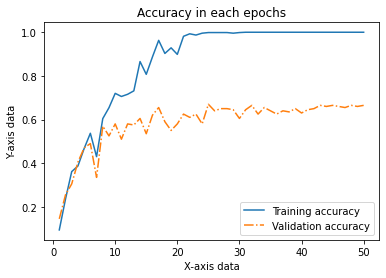

In [ ]:
model5 = classifier3(50,train_data_loader,val_data_loader)

Epoch [1/100]: 100%|██████████| 22/22 [00:06<00:00,  3.35it/s, loss=4.69]


Epoch 1,loss 4.6881, Accuracy 0.13857142627239227, ValAccuracy 0.14000000059604645


Epoch [2/100]: 100%|██████████| 22/22 [00:06<00:00,  3.63it/s, loss=1.98]


Epoch 2,loss 1.9791, Accuracy 0.20142856240272522, ValAccuracy 0.23499999940395355


Epoch [3/100]: 100%|██████████| 22/22 [00:05<00:00,  3.73it/s, loss=1.87]


Epoch 3,loss 1.8736, Accuracy 0.24857142567634583, ValAccuracy 0.2549999952316284


Epoch [4/100]: 100%|██████████| 22/22 [00:06<00:00,  3.67it/s, loss=1.78]


Epoch 4,loss 1.7792, Accuracy 0.28142857551574707, ValAccuracy 0.25999999046325684


Epoch [5/100]: 100%|██████████| 22/22 [00:06<00:00,  3.66it/s, loss=1.8]


Epoch 5,loss 1.8010, Accuracy 0.26428571343421936, ValAccuracy 0.3050000071525574


Epoch [6/100]: 100%|██████████| 22/22 [00:06<00:00,  3.33it/s, loss=1.71]


Epoch 6,loss 1.7129, Accuracy 0.3385714292526245, ValAccuracy 0.3799999952316284


Epoch [7/100]: 100%|██████████| 22/22 [00:06<00:00,  3.16it/s, loss=1.62]


Epoch 7,loss 1.6213, Accuracy 0.3285714387893677, ValAccuracy 0.3649999797344208


Epoch [8/100]: 100%|██████████| 22/22 [00:06<00:00,  3.46it/s, loss=1.5]


Epoch 8,loss 1.5045, Accuracy 0.34285715222358704, ValAccuracy 0.3349999785423279


Epoch [9/100]: 100%|██████████| 22/22 [00:06<00:00,  3.63it/s, loss=1.47]


Epoch 9,loss 1.4684, Accuracy 0.345714271068573, ValAccuracy 0.3649999797344208


Epoch [10/100]: 100%|██████████| 22/22 [00:05<00:00,  3.68it/s, loss=1.58]


Epoch 10,loss 1.5805, Accuracy 0.2671428620815277, ValAccuracy 0.29999998211860657


Epoch [11/100]: 100%|██████████| 22/22 [00:05<00:00,  3.68it/s, loss=1.65]


Epoch 11,loss 1.6510, Accuracy 0.25999999046325684, ValAccuracy 0.3100000023841858


Epoch [12/100]: 100%|██████████| 22/22 [00:06<00:00,  3.58it/s, loss=1.61]


Epoch 12,loss 1.6067, Accuracy 0.27571427822113037, ValAccuracy 0.26999998092651367


Epoch [13/100]: 100%|██████████| 22/22 [00:06<00:00,  3.19it/s, loss=1.47]


Epoch 13,loss 1.4747, Accuracy 0.41428571939468384, ValAccuracy 0.42499998211860657


Epoch [14/100]: 100%|██████████| 22/22 [00:07<00:00,  2.80it/s, loss=1.37]


Epoch 14,loss 1.3727, Accuracy 0.3642857074737549, ValAccuracy 0.3649999797344208


Epoch [15/100]: 100%|██████████| 22/22 [00:06<00:00,  3.64it/s, loss=1.28]


Epoch 15,loss 1.2832, Accuracy 0.3257142901420593, ValAccuracy 0.32499998807907104


Epoch [16/100]: 100%|██████████| 22/22 [00:06<00:00,  3.63it/s, loss=1.21]


Epoch 16,loss 1.2128, Accuracy 0.4571428596973419, ValAccuracy 0.41999998688697815


Epoch [17/100]: 100%|██████████| 22/22 [00:05<00:00,  3.73it/s, loss=1.13]


Epoch 17,loss 1.1338, Accuracy 0.3928571343421936, ValAccuracy 0.3700000047683716


Epoch [18/100]: 100%|██████████| 22/22 [00:06<00:00,  3.49it/s, loss=1.12]


Epoch 18,loss 1.1228, Accuracy 0.4171428382396698, ValAccuracy 0.3649999797344208


Epoch [19/100]: 100%|██████████| 22/22 [00:06<00:00,  3.21it/s, loss=1.19]


Epoch 19,loss 1.1947, Accuracy 0.5400000214576721, ValAccuracy 0.48499998450279236


Epoch [20/100]: 100%|██████████| 22/22 [00:06<00:00,  3.41it/s, loss=1.1]


Epoch 20,loss 1.0964, Accuracy 0.4585714340209961, ValAccuracy 0.42499998211860657


Epoch [21/100]: 100%|██████████| 22/22 [00:06<00:00,  3.64it/s, loss=0.971]


Epoch 21,loss 0.9707, Accuracy 0.604285717010498, ValAccuracy 0.5149999856948853


Epoch [22/100]: 100%|██████████| 22/22 [00:05<00:00,  3.68it/s, loss=1.01]


Epoch 22,loss 1.0092, Accuracy 0.6228571534156799, ValAccuracy 0.5149999856948853


Epoch [23/100]: 100%|██████████| 22/22 [00:06<00:00,  3.63it/s, loss=0.869]


Epoch 23,loss 0.8694, Accuracy 0.46142855286598206, ValAccuracy 0.3799999952316284


Epoch [24/100]: 100%|██████████| 22/22 [00:05<00:00,  3.68it/s, loss=0.838]


Epoch 24,loss 0.8377, Accuracy 0.6971428394317627, ValAccuracy 0.5649999976158142


Epoch [25/100]: 100%|██████████| 22/22 [00:06<00:00,  3.36it/s, loss=0.679]


Epoch 25,loss 0.6789, Accuracy 0.727142870426178, ValAccuracy 0.5299999713897705


Epoch [26/100]: 100%|██████████| 22/22 [00:06<00:00,  3.19it/s, loss=0.688]


Epoch 26,loss 0.6878, Accuracy 0.5999999642372131, ValAccuracy 0.47999998927116394


Epoch [27/100]: 100%|██████████| 22/22 [00:06<00:00,  3.43it/s, loss=0.779]


Epoch 27,loss 0.7790, Accuracy 0.5742856860160828, ValAccuracy 0.4599999785423279


Epoch [28/100]: 100%|██████████| 22/22 [00:06<00:00,  3.63it/s, loss=0.59]


Epoch 28,loss 0.5896, Accuracy 0.6014285683631897, ValAccuracy 0.4650000035762787


Epoch [29/100]: 100%|██████████| 22/22 [00:05<00:00,  3.70it/s, loss=0.553]


Epoch 29,loss 0.5532, Accuracy 0.8728571534156799, ValAccuracy 0.5849999785423279


Epoch [30/100]: 100%|██████████| 22/22 [00:06<00:00,  3.65it/s, loss=0.52]


Epoch 30,loss 0.5201, Accuracy 0.6757142543792725, ValAccuracy 0.4650000035762787


Epoch [31/100]: 100%|██████████| 22/22 [00:06<00:00,  3.30it/s, loss=0.52]


Epoch 31,loss 0.5202, Accuracy 0.8842856884002686, ValAccuracy 0.5550000071525574


Epoch [32/100]: 100%|██████████| 22/22 [00:07<00:00,  3.10it/s, loss=0.342]


Epoch 32,loss 0.3416, Accuracy 0.941428542137146, ValAccuracy 0.5349999666213989


Epoch [33/100]: 100%|██████████| 22/22 [00:06<00:00,  3.45it/s, loss=0.246]


Epoch 33,loss 0.2461, Accuracy 0.9385713934898376, ValAccuracy 0.5799999833106995


Epoch [34/100]: 100%|██████████| 22/22 [00:06<00:00,  3.64it/s, loss=0.187]


Epoch 34,loss 0.1866, Accuracy 0.9728571176528931, ValAccuracy 0.574999988079071


Epoch [35/100]: 100%|██████████| 22/22 [00:05<00:00,  3.68it/s, loss=0.132]


Epoch 35,loss 0.1318, Accuracy 0.9542856812477112, ValAccuracy 0.574999988079071


Epoch [36/100]: 100%|██████████| 22/22 [00:05<00:00,  3.67it/s, loss=0.126]


Epoch 36,loss 0.1256, Accuracy 0.9357143044471741, ValAccuracy 0.5550000071525574


Epoch [37/100]: 100%|██████████| 22/22 [00:06<00:00,  3.50it/s, loss=0.0924]


Epoch 37,loss 0.0924, Accuracy 0.9257142543792725, ValAccuracy 0.5399999618530273


Epoch [38/100]: 100%|██████████| 22/22 [00:06<00:00,  3.18it/s, loss=0.111]


Epoch 38,loss 0.1107, Accuracy 0.9871428608894348, ValAccuracy 0.5699999928474426


Epoch [39/100]: 100%|██████████| 22/22 [00:06<00:00,  3.43it/s, loss=0.0704]


Epoch 39,loss 0.0704, Accuracy 0.9942857027053833, ValAccuracy 0.5949999690055847


Epoch [40/100]: 100%|██████████| 22/22 [00:06<00:00,  3.64it/s, loss=0.0511]


Epoch 40,loss 0.0511, Accuracy 0.9842857122421265, ValAccuracy 0.5899999737739563


Epoch [41/100]: 100%|██████████| 22/22 [00:05<00:00,  3.70it/s, loss=0.0546]


Epoch 41,loss 0.0546, Accuracy 0.9928571581840515, ValAccuracy 0.6100000143051147


Epoch [42/100]: 100%|██████████| 22/22 [00:05<00:00,  3.71it/s, loss=0.042]


Epoch 42,loss 0.0420, Accuracy 0.9957142472267151, ValAccuracy 0.5849999785423279


Epoch [43/100]: 100%|██████████| 22/22 [00:06<00:00,  3.56it/s, loss=0.0276]


Epoch 43,loss 0.0276, Accuracy 0.9971428513526917, ValAccuracy 0.5799999833106995


Epoch [44/100]: 100%|██████████| 22/22 [00:06<00:00,  3.24it/s, loss=0.0221]


Epoch 44,loss 0.0221, Accuracy 0.9985713958740234, ValAccuracy 0.5799999833106995


Epoch [45/100]: 100%|██████████| 22/22 [00:07<00:00,  3.12it/s, loss=0.016]


Epoch 45,loss 0.0160, Accuracy 0.9985713958740234, ValAccuracy 0.5799999833106995


Epoch [46/100]: 100%|██████████| 22/22 [00:06<00:00,  3.62it/s, loss=0.0135]


Epoch 46,loss 0.0135, Accuracy 0.9985713958740234, ValAccuracy 0.574999988079071


Epoch [47/100]: 100%|██████████| 22/22 [00:06<00:00,  3.63it/s, loss=0.00738]


Epoch 47,loss 0.0074, Accuracy 0.9985713958740234, ValAccuracy 0.5699999928474426


Epoch [48/100]: 100%|██████████| 22/22 [00:06<00:00,  3.64it/s, loss=0.00813]


Epoch 48,loss 0.0081, Accuracy 0.9985713958740234, ValAccuracy 0.5699999928474426


Epoch [49/100]: 100%|██████████| 22/22 [00:05<00:00,  3.70it/s, loss=0.00621]


Epoch 49,loss 0.0062, Accuracy 0.9985713958740234, ValAccuracy 0.5799999833106995


Epoch [50/100]: 100%|██████████| 22/22 [00:06<00:00,  3.25it/s, loss=0.00573]


Epoch 50,loss 0.0057, Accuracy 0.9985713958740234, ValAccuracy 0.5849999785423279


Epoch [51/100]: 100%|██████████| 22/22 [00:06<00:00,  3.21it/s, loss=0.008]


Epoch 51,loss 0.0080, Accuracy 1.0, ValAccuracy 0.5699999928474426


Epoch [52/100]: 100%|██████████| 22/22 [00:06<00:00,  3.59it/s, loss=0.00814]


Epoch 52,loss 0.0081, Accuracy 0.9985713958740234, ValAccuracy 0.5899999737739563


Epoch [53/100]: 100%|██████████| 22/22 [00:06<00:00,  3.62it/s, loss=0.00864]


Epoch 53,loss 0.0086, Accuracy 1.0, ValAccuracy 0.5799999833106995


Epoch [54/100]: 100%|██████████| 22/22 [00:05<00:00,  3.68it/s, loss=0.00578]


Epoch 54,loss 0.0058, Accuracy 1.0, ValAccuracy 0.5799999833106995


Epoch [55/100]: 100%|██████████| 22/22 [00:06<00:00,  3.64it/s, loss=0.00327]


Epoch 55,loss 0.0033, Accuracy 1.0, ValAccuracy 0.5949999690055847


Epoch [56/100]: 100%|██████████| 22/22 [00:06<00:00,  3.39it/s, loss=0.00385]


Epoch 56,loss 0.0038, Accuracy 1.0, ValAccuracy 0.6049999594688416


Epoch [57/100]: 100%|██████████| 22/22 [00:06<00:00,  3.22it/s, loss=0.00233]


Epoch 57,loss 0.0023, Accuracy 1.0, ValAccuracy 0.5949999690055847


Epoch [58/100]: 100%|██████████| 22/22 [00:06<00:00,  3.38it/s, loss=0.00233]


Epoch 58,loss 0.0023, Accuracy 1.0, ValAccuracy 0.6049999594688416


Epoch [59/100]: 100%|██████████| 22/22 [00:06<00:00,  3.58it/s, loss=0.00171]


Epoch 59,loss 0.0017, Accuracy 1.0, ValAccuracy 0.5799999833106995


Epoch [60/100]: 100%|██████████| 22/22 [00:06<00:00,  3.64it/s, loss=0.00187]


Epoch 60,loss 0.0019, Accuracy 1.0, ValAccuracy 0.5949999690055847


Epoch [61/100]: 100%|██████████| 22/22 [00:06<00:00,  3.61it/s, loss=0.00126]


Epoch 61,loss 0.0013, Accuracy 1.0, ValAccuracy 0.5899999737739563


Epoch [62/100]: 100%|██████████| 22/22 [00:05<00:00,  3.67it/s, loss=0.00124]


Epoch 62,loss 0.0012, Accuracy 1.0, ValAccuracy 0.5999999642372131


Epoch [63/100]: 100%|██████████| 22/22 [00:06<00:00,  3.56it/s, loss=0.0907]


Epoch 63,loss 0.0907, Accuracy 0.8799999952316284, ValAccuracy 0.5099999904632568


Epoch [64/100]: 100%|██████████| 22/22 [00:07<00:00,  3.08it/s, loss=0.105]


Epoch 64,loss 0.1048, Accuracy 0.9328571557998657, ValAccuracy 0.5249999761581421


Epoch [65/100]: 100%|██████████| 22/22 [00:06<00:00,  3.25it/s, loss=0.129]


Epoch 65,loss 0.1289, Accuracy 0.9742857217788696, ValAccuracy 0.574999988079071


Epoch [66/100]: 100%|██████████| 22/22 [00:06<00:00,  3.32it/s, loss=0.0697]


Epoch 66,loss 0.0697, Accuracy 0.949999988079071, ValAccuracy 0.5199999809265137


Epoch [67/100]: 100%|██████████| 22/22 [00:06<00:00,  3.61it/s, loss=0.0489]


Epoch 67,loss 0.0489, Accuracy 0.977142870426178, ValAccuracy 0.5949999690055847


Epoch [68/100]: 100%|██████████| 22/22 [00:05<00:00,  3.69it/s, loss=0.0349]


Epoch 68,loss 0.0349, Accuracy 0.9814285635948181, ValAccuracy 0.5550000071525574


Epoch [69/100]: 100%|██████████| 22/22 [00:05<00:00,  3.71it/s, loss=0.0324]


Epoch 69,loss 0.0324, Accuracy 0.9942857027053833, ValAccuracy 0.5799999833106995


Epoch [70/100]: 100%|██████████| 22/22 [00:06<00:00,  3.62it/s, loss=0.0164]


Epoch 70,loss 0.0164, Accuracy 0.9985713958740234, ValAccuracy 0.5600000023841858


Epoch [71/100]: 100%|██████████| 22/22 [00:06<00:00,  3.36it/s, loss=0.00582]


Epoch 71,loss 0.0058, Accuracy 1.0, ValAccuracy 0.5649999976158142


Epoch [72/100]: 100%|██████████| 22/22 [00:07<00:00,  3.09it/s, loss=0.00303]


Epoch 72,loss 0.0030, Accuracy 1.0, ValAccuracy 0.5849999785423279


Epoch [73/100]: 100%|██████████| 22/22 [00:06<00:00,  3.44it/s, loss=0.00238]


Epoch 73,loss 0.0024, Accuracy 1.0, ValAccuracy 0.5699999928474426


Epoch [74/100]: 100%|██████████| 22/22 [00:06<00:00,  3.55it/s, loss=0.00223]


Epoch 74,loss 0.0022, Accuracy 1.0, ValAccuracy 0.5600000023841858


Epoch [75/100]: 100%|██████████| 22/22 [00:06<00:00,  3.66it/s, loss=0.00125]


Epoch 75,loss 0.0013, Accuracy 1.0, ValAccuracy 0.574999988079071


Epoch [76/100]: 100%|██████████| 22/22 [00:06<00:00,  3.15it/s, loss=0.00101]


Epoch 76,loss 0.0010, Accuracy 1.0, ValAccuracy 0.5699999928474426


Epoch [77/100]: 100%|██████████| 22/22 [00:05<00:00,  3.67it/s, loss=0.000869]


Epoch 77,loss 0.0009, Accuracy 1.0, ValAccuracy 0.5899999737739563


Epoch [78/100]: 100%|██████████| 22/22 [00:06<00:00,  3.51it/s, loss=0.000905]


Epoch 78,loss 0.0009, Accuracy 1.0, ValAccuracy 0.5799999833106995


Epoch [79/100]: 100%|██████████| 22/22 [00:06<00:00,  3.17it/s, loss=0.000897]


Epoch 79,loss 0.0009, Accuracy 1.0, ValAccuracy 0.5849999785423279


Epoch [80/100]: 100%|██████████| 22/22 [00:07<00:00,  2.87it/s, loss=0.000661]


Epoch 80,loss 0.0007, Accuracy 1.0, ValAccuracy 0.5849999785423279


Epoch [81/100]: 100%|██████████| 22/22 [00:06<00:00,  3.39it/s, loss=0.000916]


Epoch 81,loss 0.0009, Accuracy 1.0, ValAccuracy 0.5799999833106995


Epoch [82/100]: 100%|██████████| 22/22 [00:06<00:00,  3.61it/s, loss=0.000598]


Epoch 82,loss 0.0006, Accuracy 1.0, ValAccuracy 0.574999988079071


Epoch [83/100]: 100%|██████████| 22/22 [00:05<00:00,  3.71it/s, loss=0.000789]


Epoch 83,loss 0.0008, Accuracy 1.0, ValAccuracy 0.574999988079071


Epoch [84/100]: 100%|██████████| 22/22 [00:06<00:00,  3.66it/s, loss=0.000738]


Epoch 84,loss 0.0007, Accuracy 1.0, ValAccuracy 0.5799999833106995


Epoch [85/100]: 100%|██████████| 22/22 [00:06<00:00,  3.60it/s, loss=0.00073]


Epoch 85,loss 0.0007, Accuracy 1.0, ValAccuracy 0.5799999833106995


Epoch [86/100]: 100%|██████████| 22/22 [00:06<00:00,  3.20it/s, loss=0.000604]


Epoch 86,loss 0.0006, Accuracy 1.0, ValAccuracy 0.574999988079071


Epoch [87/100]: 100%|██████████| 22/22 [00:06<00:00,  3.23it/s, loss=0.000484]


Epoch 87,loss 0.0005, Accuracy 1.0, ValAccuracy 0.574999988079071


Epoch [88/100]: 100%|██████████| 22/22 [00:06<00:00,  3.59it/s, loss=0.000441]


Epoch 88,loss 0.0004, Accuracy 1.0, ValAccuracy 0.5849999785423279


Epoch [89/100]: 100%|██████████| 22/22 [00:06<00:00,  3.63it/s, loss=0.000444]


Epoch 89,loss 0.0004, Accuracy 1.0, ValAccuracy 0.5799999833106995


Epoch [90/100]: 100%|██████████| 22/22 [00:06<00:00,  3.64it/s, loss=0.000465]


Epoch 90,loss 0.0005, Accuracy 1.0, ValAccuracy 0.574999988079071


Epoch [91/100]: 100%|██████████| 22/22 [00:06<00:00,  3.64it/s, loss=0.000404]


Epoch 91,loss 0.0004, Accuracy 1.0, ValAccuracy 0.5699999928474426


Epoch [92/100]: 100%|██████████| 22/22 [00:06<00:00,  3.65it/s, loss=0.000458]


Epoch 92,loss 0.0005, Accuracy 1.0, ValAccuracy 0.574999988079071


Epoch [93/100]: 100%|██████████| 22/22 [00:06<00:00,  3.27it/s, loss=0.000406]


Epoch 93,loss 0.0004, Accuracy 1.0, ValAccuracy 0.5799999833106995


Epoch [94/100]: 100%|██████████| 22/22 [00:06<00:00,  3.16it/s, loss=0.000285]


Epoch 94,loss 0.0003, Accuracy 1.0, ValAccuracy 0.5799999833106995


Epoch [95/100]: 100%|██████████| 22/22 [00:06<00:00,  3.39it/s, loss=0.000342]


Epoch 95,loss 0.0003, Accuracy 1.0, ValAccuracy 0.5849999785423279


Epoch [96/100]: 100%|██████████| 22/22 [00:06<00:00,  3.40it/s, loss=0.000305]


Epoch 96,loss 0.0003, Accuracy 1.0, ValAccuracy 0.5849999785423279


Epoch [97/100]: 100%|██████████| 22/22 [00:06<00:00,  3.63it/s, loss=0.000605]


Epoch 97,loss 0.0006, Accuracy 1.0, ValAccuracy 0.5949999690055847


Epoch [98/100]: 100%|██████████| 22/22 [00:06<00:00,  3.63it/s, loss=0.000307]


Epoch 98,loss 0.0003, Accuracy 1.0, ValAccuracy 0.5849999785423279


Epoch [99/100]: 100%|██████████| 22/22 [00:06<00:00,  3.65it/s, loss=0.000273]


Epoch 99,loss 0.0003, Accuracy 1.0, ValAccuracy 0.5849999785423279


Epoch [100/100]: 100%|██████████| 22/22 [00:06<00:00,  3.55it/s, loss=0.000246]


Epoch 100,loss 0.0002, Accuracy 1.0, ValAccuracy 0.5849999785423279


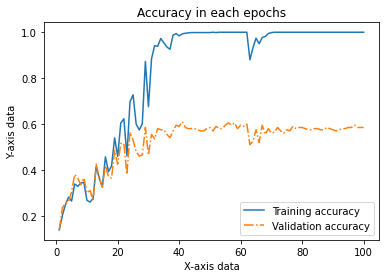

In [ ]:
model6 = classifier3(100,train_data_loader,val_data_loader)

In [ ]:
#Model Description
for c in model5.children():
    print(c)

ReLU()
Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
Conv2d(128, 32, kernel_size=(5, 5), stride=(1, 1))
MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
Flatten(start_dim=1, end_dim=-1)
Linear(in_features=51200, out_features=256, bias=True)
Linear(in_features=256, out_features=10, bias=True)
BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


## CLASSIFIERS USING RMS OPTIMISER

In [ ]:
#Training 1st FeedForward Neural Netork with RMSOptimiser
def classifier4(epochs,train_data_loader,val_data_loader):
  model=Net(input_size,output_size)

  model=model.cuda()

  # Setting the optimiser
  optimizer=torch.optim.RMSprop(model.parameters(),lr=0.001)

  #Setting loss function
  loss_fn=nn.CrossEntropyLoss()
  running_loss=0.0

  #List to store accuracy of model after each epoch
  train_acc=[]
  val_acc = []
  
  #Training the model
  for epoch in range(epochs):
      correct = 0
      for imgs,labels in train_data_loader:
          imgs=imgs.cuda()
          labels=labels.cuda()
          output=model(imgs)
          loss=loss_fn(output,labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          #Calculating Running Loss
          running_loss=0.99*running_loss+0.01*loss.item()        
          # _,predicted=torch.max(output.data,1)
          # correct+=(predicted==labels).sum()
      
      model.eval()
      #Getting model accuracy for train and validation
      train_accuracy = get_accuracy(train_data_loader,model,device) 
      val_accuracy = get_accuracy(val_data_loader,model,device)
      model.train()
      
      train_acc.append(train_accuracy)
      val_acc.append(val_accuracy)
      print("Epoch {},loss {:.4f}, Accuracy {}, ValAccuracy {}".format(epoch+1,running_loss,train_accuracy,val_accuracy))
  
  print()
  #Visualising the accuracy
  visualise_training(epochs,train_acc,val_acc)

  return model


In [ ]:
#Training 1st Convolution Neural Netork with RMSOptimiser
def classifier5(epochs,train_data_loader,val_data_loader):

  model=Net2().to(device)
  optimizer=torch.optim.RMSprop(model.parameters(),lr=0.001)
  loss_fn=nn.CrossEntropyLoss()

  train_acc=[]
  val_acc = []

  for epoch in range(epochs):
      loop=tqdm(train_data_loader)
      loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
      epoch_loss=0.
      for (imgs,labels) in loop:
          optimizer.zero_grad()
          imgs=imgs.to(device)
          labels=labels.to(device)
          outputs=model(imgs)
          loss=loss_fn(outputs,labels)
          loss.backward()
          optimizer.step()
          epoch_loss=0.9*epoch_loss+0.1*loss.item()
          loop.set_postfix(loss=epoch_loss)

      model.eval()
      t_acc=get_accuracy(train_data_loader,model,device) 
      v_acc=get_accuracy(val_data_loader,model,device)
      train_acc.append(t_acc)
      val_acc.append(v_acc)
      model.train()

      print("Epoch {},loss {:.4f}, Accuracy {}, ValAccuracy {}".format(epoch+1,epoch_loss,t_acc,v_acc))
      
  #     writer.add_scalar("loss",epoch_loss,epoch)
  #     writer.add_scalars("acc",{'train':t_acc,'valid':v_acc},epoch)
  # writer.close()   
  
  visualise_training(epochs,train_acc,val_acc)

  return model

In [ ]:
#Training 2nd Convolution Neural Netork with RMSOptimiser
def classifier6(epochs,train_data_loader,val_data_loader):

  model=Net3().to(device)
  optimizer=torch.optim.RMSprop(model.parameters(),lr=0.001)
  loss_fn=nn.CrossEntropyLoss()

  train_acc=[]
  val_acc = []

  for epoch in range(epochs):
      loop=tqdm(train_data_loader)
      loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
      epoch_loss=0.
      for (imgs,labels) in loop:
          optimizer.zero_grad()
          imgs=imgs.to(device)
          labels=labels.to(device)
          outputs=model(imgs)
          loss=loss_fn(outputs,labels)
          loss.backward()
          optimizer.step()
          epoch_loss=0.9*epoch_loss+0.1*loss.item()
          loop.set_postfix(loss=epoch_loss)

      model.eval()
      t_acc=get_accuracy(train_data_loader,model,device) 
      v_acc=get_accuracy(val_data_loader,model,device)
      train_acc.append(t_acc)
      val_acc.append(v_acc)
      model.train()

      print("Epoch {},loss {:.4f}, Accuracy {}, ValAccuracy {}".format(epoch+1,epoch_loss,t_acc,v_acc))
      
  #     writer.add_scalar("loss",epoch_loss,epoch)
  #     writer.add_scalars("acc",{'train':t_acc,'valid':v_acc},epoch)
  # writer.close()   
  
  visualise_training(epochs,train_acc,val_acc)

  return model

Epoch 1,loss 7.5736, Accuracy 0.1971428543329239, ValAccuracy 0.1899999976158142
Epoch 2,loss 6.5089, Accuracy 0.20428571105003357, ValAccuracy 0.1899999976158142
Epoch 3,loss 5.6341, Accuracy 0.23000000417232513, ValAccuracy 0.22499999403953552
Epoch 4,loss 4.9364, Accuracy 0.21571429073810577, ValAccuracy 0.23499999940395355
Epoch 5,loss 4.3782, Accuracy 0.19285714626312256, ValAccuracy 0.20999999344348907
Epoch 6,loss 3.9258, Accuracy 0.22714285552501678, ValAccuracy 0.29499998688697815
Epoch 7,loss 3.5578, Accuracy 0.25285714864730835, ValAccuracy 0.19999998807907104
Epoch 8,loss 3.2769, Accuracy 0.1899999976158142, ValAccuracy 0.20999999344348907
Epoch 9,loss 3.0431, Accuracy 0.2085714191198349, ValAccuracy 0.19999998807907104
Epoch 10,loss 2.8492, Accuracy 0.20428571105003357, ValAccuracy 0.2449999898672104
Epoch 11,loss 2.7049, Accuracy 0.18142856657505035, ValAccuracy 0.22499999403953552
Epoch 12,loss 2.5818, Accuracy 0.22857142984867096, ValAccuracy 0.25
Epoch 13,loss 2.4788, 

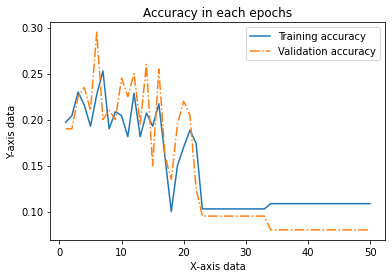

In [ ]:
model7 = classifier4(50,train_data_loader,val_data_loader)

Epoch 1,loss 7.5572, Accuracy 0.10285714268684387, ValAccuracy 0.0949999988079071
Epoch 2,loss 6.5153, Accuracy 0.10285714268684387, ValAccuracy 0.0949999988079071
Epoch 3,loss 5.6797, Accuracy 0.10285714268684387, ValAccuracy 0.0949999988079071
Epoch 4,loss 5.0099, Accuracy 0.10285714268684387, ValAccuracy 0.0949999988079071
Epoch 5,loss 4.4729, Accuracy 0.10285714268684387, ValAccuracy 0.0949999988079071
Epoch 6,loss 4.0424, Accuracy 0.10285714268684387, ValAccuracy 0.0949999988079071
Epoch 7,loss 3.6973, Accuracy 0.10285714268684387, ValAccuracy 0.0949999988079071
Epoch 8,loss 3.4206, Accuracy 0.10285714268684387, ValAccuracy 0.0949999988079071
Epoch 9,loss 3.1988, Accuracy 0.10285714268684387, ValAccuracy 0.0949999988079071
Epoch 10,loss 3.0210, Accuracy 0.10285714268684387, ValAccuracy 0.0949999988079071
Epoch 11,loss 2.8785, Accuracy 0.10285714268684387, ValAccuracy 0.0949999988079071
Epoch 12,loss 2.7642, Accuracy 0.10285714268684387, ValAccuracy 0.0949999988079071
Epoch 13,loss

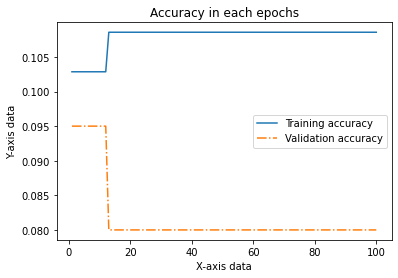

In [ ]:
model8 = classifier4(100,train_data_loader,val_data_loader)

Epoch [1/50]: 100%|██████████| 22/22 [00:05<00:00,  3.92it/s, loss=13.8]


Epoch 1,loss 13.8123, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [2/50]: 100%|██████████| 22/22 [00:05<00:00,  3.97it/s, loss=2.08]


Epoch 2,loss 2.0769, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [3/50]: 100%|██████████| 22/22 [00:05<00:00,  3.98it/s, loss=2.08]


Epoch 3,loss 2.0765, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [4/50]: 100%|██████████| 22/22 [00:05<00:00,  4.08it/s, loss=2.08]


Epoch 4,loss 2.0772, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [5/50]: 100%|██████████| 22/22 [00:06<00:00,  3.60it/s, loss=2.08]


Epoch 5,loss 2.0768, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [6/50]: 100%|██████████| 22/22 [00:06<00:00,  3.28it/s, loss=2.08]


Epoch 6,loss 2.0767, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [7/50]: 100%|██████████| 22/22 [00:05<00:00,  3.92it/s, loss=2.08]


Epoch 7,loss 2.0761, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [8/50]: 100%|██████████| 22/22 [00:05<00:00,  4.06it/s, loss=2.08]


Epoch 8,loss 2.0773, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [9/50]: 100%|██████████| 22/22 [00:05<00:00,  3.89it/s, loss=2.08]


Epoch 9,loss 2.0755, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [10/50]: 100%|██████████| 22/22 [00:05<00:00,  3.98it/s, loss=2.08]


Epoch 10,loss 2.0769, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [11/50]: 100%|██████████| 22/22 [00:05<00:00,  3.68it/s, loss=2.08]


Epoch 11,loss 2.0767, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [12/50]: 100%|██████████| 22/22 [00:06<00:00,  3.27it/s, loss=2.08]


Epoch 12,loss 2.0756, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [13/50]: 100%|██████████| 22/22 [00:06<00:00,  3.54it/s, loss=2.08]


Epoch 13,loss 2.0755, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [14/50]: 100%|██████████| 22/22 [00:05<00:00,  3.97it/s, loss=2.07]


Epoch 14,loss 2.0746, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [15/50]: 100%|██████████| 22/22 [00:05<00:00,  3.99it/s, loss=2.08]


Epoch 15,loss 2.0753, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [16/50]: 100%|██████████| 22/22 [00:06<00:00,  3.55it/s, loss=2.08]


Epoch 16,loss 2.0750, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [17/50]: 100%|██████████| 22/22 [00:05<00:00,  4.03it/s, loss=2.08]


Epoch 17,loss 2.0760, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [18/50]: 100%|██████████| 22/22 [00:05<00:00,  3.71it/s, loss=2.08]


Epoch 18,loss 2.0760, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [19/50]: 100%|██████████| 22/22 [00:06<00:00,  3.31it/s, loss=2.08]


Epoch 19,loss 2.0755, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [20/50]: 100%|██████████| 22/22 [00:06<00:00,  3.63it/s, loss=2.08]


Epoch 20,loss 2.0763, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [21/50]: 100%|██████████| 22/22 [00:05<00:00,  4.07it/s, loss=2.08]


Epoch 21,loss 2.0762, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [22/50]: 100%|██████████| 22/22 [00:05<00:00,  4.01it/s, loss=2.08]


Epoch 22,loss 2.0768, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [23/50]: 100%|██████████| 22/22 [00:05<00:00,  4.08it/s, loss=2.08]


Epoch 23,loss 2.0754, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [24/50]: 100%|██████████| 22/22 [00:05<00:00,  3.71it/s, loss=2.08]


Epoch 24,loss 2.0751, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [25/50]: 100%|██████████| 22/22 [00:06<00:00,  3.26it/s, loss=2.08]


Epoch 25,loss 2.0756, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [26/50]: 100%|██████████| 22/22 [00:05<00:00,  3.78it/s, loss=2.08]


Epoch 26,loss 2.0751, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [27/50]: 100%|██████████| 22/22 [00:05<00:00,  3.96it/s, loss=2.07]


Epoch 27,loss 2.0743, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [28/50]: 100%|██████████| 22/22 [00:05<00:00,  4.04it/s, loss=2.08]


Epoch 28,loss 2.0762, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [29/50]: 100%|██████████| 22/22 [00:05<00:00,  4.06it/s, loss=2.08]


Epoch 29,loss 2.0756, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [30/50]: 100%|██████████| 22/22 [00:05<00:00,  3.69it/s, loss=2.08]


Epoch 30,loss 2.0756, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [31/50]: 100%|██████████| 22/22 [00:06<00:00,  3.25it/s, loss=2.08]


Epoch 31,loss 2.0767, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [32/50]: 100%|██████████| 22/22 [00:06<00:00,  3.19it/s, loss=2.07]


Epoch 32,loss 2.0739, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [33/50]: 100%|██████████| 22/22 [00:05<00:00,  4.03it/s, loss=2.07]


Epoch 33,loss 2.0745, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [34/50]: 100%|██████████| 22/22 [00:05<00:00,  4.09it/s, loss=2.08]


Epoch 34,loss 2.0774, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [35/50]: 100%|██████████| 22/22 [00:05<00:00,  4.04it/s, loss=2.08]


Epoch 35,loss 2.0762, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [36/50]: 100%|██████████| 22/22 [00:06<00:00,  3.48it/s, loss=2.08]


Epoch 36,loss 2.0765, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [37/50]: 100%|██████████| 22/22 [00:06<00:00,  3.41it/s, loss=2.08]


Epoch 37,loss 2.0755, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [38/50]: 100%|██████████| 22/22 [00:05<00:00,  3.92it/s, loss=2.08]


Epoch 38,loss 2.0757, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [39/50]: 100%|██████████| 22/22 [00:05<00:00,  4.03it/s, loss=2.08]


Epoch 39,loss 2.0751, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [40/50]: 100%|██████████| 22/22 [00:05<00:00,  4.04it/s, loss=2.08]


Epoch 40,loss 2.0766, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [41/50]: 100%|██████████| 22/22 [00:05<00:00,  3.86it/s, loss=2.08]


Epoch 41,loss 2.0756, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [42/50]: 100%|██████████| 22/22 [00:06<00:00,  3.25it/s, loss=2.07]


Epoch 42,loss 2.0746, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [43/50]: 100%|██████████| 22/22 [00:06<00:00,  3.53it/s, loss=2.07]


Epoch 43,loss 2.0749, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [44/50]: 100%|██████████| 22/22 [00:05<00:00,  3.98it/s, loss=2.08]


Epoch 44,loss 2.0766, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [45/50]: 100%|██████████| 22/22 [00:05<00:00,  4.08it/s, loss=2.08]


Epoch 45,loss 2.0762, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [46/50]: 100%|██████████| 22/22 [00:05<00:00,  4.04it/s, loss=2.07]


Epoch 46,loss 2.0744, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [47/50]: 100%|██████████| 22/22 [00:05<00:00,  3.83it/s, loss=2.07]


Epoch 47,loss 2.0748, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [48/50]: 100%|██████████| 22/22 [00:06<00:00,  3.22it/s, loss=2.08]


Epoch 48,loss 2.0775, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [49/50]: 100%|██████████| 22/22 [00:06<00:00,  3.32it/s, loss=2.07]


Epoch 49,loss 2.0739, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [50/50]: 100%|██████████| 22/22 [00:05<00:00,  3.93it/s, loss=2.08]


Epoch 50,loss 2.0753, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


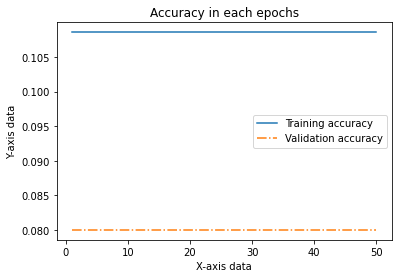

In [ ]:
model9 = classifier5(50,train_data_loader,val_data_loader)

Epoch [1/100]: 100%|██████████| 22/22 [00:05<00:00,  3.97it/s, loss=9.28]


Epoch 1,loss 9.2758, Accuracy 0.10285714268684387, ValAccuracy 0.0949999988079071


Epoch [2/100]: 100%|██████████| 22/22 [00:05<00:00,  3.98it/s, loss=2.08]


Epoch 2,loss 2.0771, Accuracy 0.10285714268684387, ValAccuracy 0.0949999988079071


Epoch [3/100]: 100%|██████████| 22/22 [00:05<00:00,  4.04it/s, loss=2.08]


Epoch 3,loss 2.0770, Accuracy 0.10285714268684387, ValAccuracy 0.0949999988079071


Epoch [4/100]: 100%|██████████| 22/22 [00:06<00:00,  3.66it/s, loss=2.08]


Epoch 4,loss 2.0758, Accuracy 0.10285714268684387, ValAccuracy 0.0949999988079071


Epoch [5/100]: 100%|██████████| 22/22 [00:06<00:00,  3.29it/s, loss=2.08]


Epoch 5,loss 2.0767, Accuracy 0.10285714268684387, ValAccuracy 0.0949999988079071


Epoch [6/100]: 100%|██████████| 22/22 [00:05<00:00,  3.75it/s, loss=2.08]


Epoch 6,loss 2.0774, Accuracy 0.10285714268684387, ValAccuracy 0.0949999988079071


Epoch [7/100]: 100%|██████████| 22/22 [00:05<00:00,  3.94it/s, loss=2.08]


Epoch 7,loss 2.0761, Accuracy 0.10285714268684387, ValAccuracy 0.0949999988079071


Epoch [8/100]: 100%|██████████| 22/22 [00:05<00:00,  4.04it/s, loss=2.08]


Epoch 8,loss 2.0762, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [9/100]: 100%|██████████| 22/22 [00:05<00:00,  4.03it/s, loss=2.08]


Epoch 9,loss 2.0775, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [10/100]: 100%|██████████| 22/22 [00:05<00:00,  3.77it/s, loss=2.08]


Epoch 10,loss 2.0759, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [11/100]: 100%|██████████| 22/22 [00:06<00:00,  3.21it/s, loss=2.08]


Epoch 11,loss 2.0754, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [12/100]: 100%|██████████| 22/22 [00:06<00:00,  3.57it/s, loss=2.08]


Epoch 12,loss 2.0768, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [13/100]: 100%|██████████| 22/22 [00:05<00:00,  3.95it/s, loss=2.08]


Epoch 13,loss 2.0760, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [14/100]: 100%|██████████| 22/22 [00:05<00:00,  3.97it/s, loss=2.08]


Epoch 14,loss 2.0755, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [15/100]: 100%|██████████| 22/22 [00:05<00:00,  3.78it/s, loss=2.08]


Epoch 15,loss 2.0764, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [16/100]: 100%|██████████| 22/22 [00:05<00:00,  3.70it/s, loss=2.07]


Epoch 16,loss 2.0749, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [17/100]: 100%|██████████| 22/22 [00:06<00:00,  3.25it/s, loss=2.08]


Epoch 17,loss 2.0758, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [18/100]: 100%|██████████| 22/22 [00:06<00:00,  3.46it/s, loss=2.08]


Epoch 18,loss 2.0765, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [19/100]: 100%|██████████| 22/22 [00:05<00:00,  3.91it/s, loss=2.08]


Epoch 19,loss 2.0759, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [20/100]: 100%|██████████| 22/22 [00:05<00:00,  4.00it/s, loss=2.08]


Epoch 20,loss 2.0754, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [21/100]: 100%|██████████| 22/22 [00:05<00:00,  3.98it/s, loss=2.08]


Epoch 21,loss 2.0756, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [22/100]: 100%|██████████| 22/22 [00:05<00:00,  3.99it/s, loss=2.08]


Epoch 22,loss 2.0755, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [23/100]: 100%|██████████| 22/22 [00:06<00:00,  3.45it/s, loss=2.08]


Epoch 23,loss 2.0764, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [24/100]: 100%|██████████| 22/22 [00:06<00:00,  3.43it/s, loss=2.08]


Epoch 24,loss 2.0775, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [25/100]: 100%|██████████| 22/22 [00:05<00:00,  3.97it/s, loss=2.08]


Epoch 25,loss 2.0756, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [26/100]: 100%|██████████| 22/22 [00:05<00:00,  3.97it/s, loss=2.07]


Epoch 26,loss 2.0729, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [27/100]: 100%|██████████| 22/22 [00:05<00:00,  4.03it/s, loss=2.07]


Epoch 27,loss 2.0749, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [28/100]: 100%|██████████| 22/22 [00:05<00:00,  4.02it/s, loss=2.08]


Epoch 28,loss 2.0752, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [29/100]: 100%|██████████| 22/22 [00:06<00:00,  3.61it/s, loss=2.08]


Epoch 29,loss 2.0750, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [30/100]: 100%|██████████| 22/22 [00:07<00:00,  3.08it/s, loss=2.08]


Epoch 30,loss 2.0759, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [31/100]: 100%|██████████| 22/22 [00:07<00:00,  2.78it/s, loss=2.07]


Epoch 31,loss 2.0750, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [32/100]: 100%|██████████| 22/22 [00:05<00:00,  4.00it/s, loss=2.07]


Epoch 32,loss 2.0740, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [33/100]: 100%|██████████| 22/22 [00:05<00:00,  4.01it/s, loss=2.08]


Epoch 33,loss 2.0752, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [34/100]: 100%|██████████| 22/22 [00:05<00:00,  4.01it/s, loss=2.08]


Epoch 34,loss 2.0759, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [35/100]: 100%|██████████| 22/22 [00:05<00:00,  4.02it/s, loss=2.07]


Epoch 35,loss 2.0741, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [36/100]: 100%|██████████| 22/22 [00:06<00:00,  3.43it/s, loss=2.08]


Epoch 36,loss 2.0764, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [37/100]: 100%|██████████| 22/22 [00:06<00:00,  3.29it/s, loss=2.07]


Epoch 37,loss 2.0747, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [38/100]: 100%|██████████| 22/22 [00:05<00:00,  3.90it/s, loss=2.07]


Epoch 38,loss 2.0746, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [39/100]: 100%|██████████| 22/22 [00:05<00:00,  3.99it/s, loss=2.07]


Epoch 39,loss 2.0748, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [40/100]: 100%|██████████| 22/22 [00:05<00:00,  4.02it/s, loss=2.07]


Epoch 40,loss 2.0733, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [41/100]: 100%|██████████| 22/22 [00:05<00:00,  3.98it/s, loss=2.08]


Epoch 41,loss 2.0751, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [42/100]: 100%|██████████| 22/22 [00:06<00:00,  3.60it/s, loss=2.07]


Epoch 42,loss 2.0745, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [43/100]: 100%|██████████| 22/22 [00:06<00:00,  3.19it/s, loss=2.08]


Epoch 43,loss 2.0773, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [44/100]: 100%|██████████| 22/22 [00:06<00:00,  3.62it/s, loss=2.08]


Epoch 44,loss 2.0760, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [45/100]: 100%|██████████| 22/22 [00:05<00:00,  3.99it/s, loss=2.08]


Epoch 45,loss 2.0765, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [46/100]: 100%|██████████| 22/22 [00:05<00:00,  3.99it/s, loss=2.08]


Epoch 46,loss 2.0754, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [47/100]: 100%|██████████| 22/22 [00:06<00:00,  3.31it/s, loss=2.08]


Epoch 47,loss 2.0763, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [48/100]: 100%|██████████| 22/22 [00:05<00:00,  4.00it/s, loss=2.08]


Epoch 48,loss 2.0762, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [49/100]: 100%|██████████| 22/22 [00:06<00:00,  3.64it/s, loss=2.08]


Epoch 49,loss 2.0755, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [50/100]: 100%|██████████| 22/22 [00:06<00:00,  3.17it/s, loss=2.08]


Epoch 50,loss 2.0767, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [51/100]: 100%|██████████| 22/22 [00:05<00:00,  3.74it/s, loss=2.07]


Epoch 51,loss 2.0736, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [52/100]: 100%|██████████| 22/22 [00:05<00:00,  3.97it/s, loss=2.08]


Epoch 52,loss 2.0771, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [53/100]: 100%|██████████| 22/22 [00:05<00:00,  3.95it/s, loss=2.07]


Epoch 53,loss 2.0748, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [54/100]: 100%|██████████| 22/22 [00:05<00:00,  4.02it/s, loss=2.08]


Epoch 54,loss 2.0761, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [55/100]: 100%|██████████| 22/22 [00:05<00:00,  3.85it/s, loss=2.08]


Epoch 55,loss 2.0752, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [56/100]: 100%|██████████| 22/22 [00:06<00:00,  3.34it/s, loss=2.07]


Epoch 56,loss 2.0743, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [57/100]: 100%|██████████| 22/22 [00:06<00:00,  3.50it/s, loss=2.08]


Epoch 57,loss 2.0751, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [58/100]: 100%|██████████| 22/22 [00:06<00:00,  3.48it/s, loss=2.08]


Epoch 58,loss 2.0765, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [59/100]: 100%|██████████| 22/22 [00:06<00:00,  3.57it/s, loss=2.08]


Epoch 59,loss 2.0763, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [60/100]: 100%|██████████| 22/22 [00:05<00:00,  4.07it/s, loss=2.08]


Epoch 60,loss 2.0762, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [61/100]: 100%|██████████| 22/22 [00:05<00:00,  3.99it/s, loss=2.08]


Epoch 61,loss 2.0772, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [62/100]: 100%|██████████| 22/22 [00:05<00:00,  3.98it/s, loss=2.07]


Epoch 62,loss 2.0745, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [63/100]: 100%|██████████| 22/22 [00:07<00:00,  2.93it/s, loss=2.08]


Epoch 63,loss 2.0753, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [64/100]: 100%|██████████| 22/22 [00:06<00:00,  3.46it/s, loss=2.07]


Epoch 64,loss 2.0739, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [65/100]: 100%|██████████| 22/22 [00:06<00:00,  3.30it/s, loss=2.08]


Epoch 65,loss 2.0768, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [66/100]: 100%|██████████| 22/22 [00:05<00:00,  3.88it/s, loss=2.08]


Epoch 66,loss 2.0765, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [67/100]: 100%|██████████| 22/22 [00:05<00:00,  4.04it/s, loss=2.07]


Epoch 67,loss 2.0747, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [68/100]: 100%|██████████| 22/22 [00:05<00:00,  3.98it/s, loss=2.08]


Epoch 68,loss 2.0759, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [69/100]: 100%|██████████| 22/22 [00:05<00:00,  4.07it/s, loss=2.08]


Epoch 69,loss 2.0765, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [70/100]: 100%|██████████| 22/22 [00:06<00:00,  3.43it/s, loss=2.08]


Epoch 70,loss 2.0762, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [71/100]: 100%|██████████| 22/22 [00:06<00:00,  3.24it/s, loss=2.08]


Epoch 71,loss 2.0757, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [72/100]: 100%|██████████| 22/22 [00:05<00:00,  3.87it/s, loss=2.08]


Epoch 72,loss 2.0761, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [73/100]: 100%|██████████| 22/22 [00:05<00:00,  4.05it/s, loss=2.07]


Epoch 73,loss 2.0749, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [74/100]: 100%|██████████| 22/22 [00:05<00:00,  4.02it/s, loss=2.08]


Epoch 74,loss 2.0753, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [75/100]: 100%|██████████| 22/22 [00:06<00:00,  3.55it/s, loss=2.08]


Epoch 75,loss 2.0758, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [76/100]: 100%|██████████| 22/22 [00:05<00:00,  3.96it/s, loss=2.07]


Epoch 76,loss 2.0749, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [77/100]: 100%|██████████| 22/22 [00:06<00:00,  3.57it/s, loss=2.08]


Epoch 77,loss 2.0758, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [78/100]: 100%|██████████| 22/22 [00:06<00:00,  3.19it/s, loss=2.07]


Epoch 78,loss 2.0745, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [79/100]: 100%|██████████| 22/22 [00:05<00:00,  3.80it/s, loss=2.08]


Epoch 79,loss 2.0759, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [80/100]: 100%|██████████| 22/22 [00:05<00:00,  3.95it/s, loss=2.08]


Epoch 80,loss 2.0775, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [81/100]: 100%|██████████| 22/22 [00:05<00:00,  3.96it/s, loss=2.08]


Epoch 81,loss 2.0750, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [82/100]: 100%|██████████| 22/22 [00:05<00:00,  4.00it/s, loss=2.08]


Epoch 82,loss 2.0767, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [83/100]: 100%|██████████| 22/22 [00:05<00:00,  3.99it/s, loss=2.07]


Epoch 83,loss 2.0747, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [84/100]: 100%|██████████| 22/22 [00:06<00:00,  3.44it/s, loss=2.08]


Epoch 84,loss 2.0757, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [85/100]: 100%|██████████| 22/22 [00:06<00:00,  3.42it/s, loss=2.07]


Epoch 85,loss 2.0738, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [86/100]: 100%|██████████| 22/22 [00:05<00:00,  3.86it/s, loss=2.07]


Epoch 86,loss 2.0736, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [87/100]: 100%|██████████| 22/22 [00:05<00:00,  4.06it/s, loss=2.08]


Epoch 87,loss 2.0763, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [88/100]: 100%|██████████| 22/22 [00:05<00:00,  3.93it/s, loss=2.07]


Epoch 88,loss 2.0747, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [89/100]: 100%|██████████| 22/22 [00:05<00:00,  3.82it/s, loss=2.08]


Epoch 89,loss 2.0766, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [90/100]: 100%|██████████| 22/22 [00:06<00:00,  3.62it/s, loss=2.07]


Epoch 90,loss 2.0741, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [91/100]: 100%|██████████| 22/22 [00:06<00:00,  3.48it/s, loss=2.08]


Epoch 91,loss 2.0752, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [92/100]: 100%|██████████| 22/22 [00:06<00:00,  3.22it/s, loss=2.07]


Epoch 92,loss 2.0733, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [93/100]: 100%|██████████| 22/22 [00:05<00:00,  3.73it/s, loss=2.08]


Epoch 93,loss 2.0760, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [94/100]: 100%|██████████| 22/22 [00:05<00:00,  3.99it/s, loss=2.07]


Epoch 94,loss 2.0735, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [95/100]: 100%|██████████| 22/22 [00:05<00:00,  3.99it/s, loss=2.07]


Epoch 95,loss 2.0748, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [96/100]: 100%|██████████| 22/22 [00:06<00:00,  3.41it/s, loss=2.08]


Epoch 96,loss 2.0774, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [97/100]: 100%|██████████| 22/22 [00:05<00:00,  4.04it/s, loss=2.08]


Epoch 97,loss 2.0753, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [98/100]: 100%|██████████| 22/22 [00:05<00:00,  3.70it/s, loss=2.07]


Epoch 98,loss 2.0744, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [99/100]: 100%|██████████| 22/22 [00:06<00:00,  3.30it/s, loss=2.07]


Epoch 99,loss 2.0749, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


Epoch [100/100]: 100%|██████████| 22/22 [00:06<00:00,  3.42it/s, loss=2.07]


Epoch 100,loss 2.0747, Accuracy 0.10857142508029938, ValAccuracy 0.07999999821186066


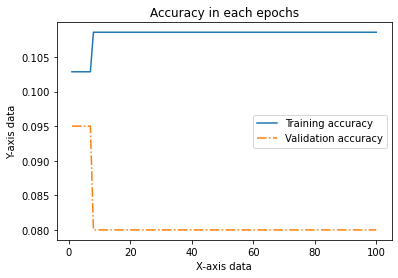

In [ ]:
model10 = classifier5(100,train_data_loader,val_data_loader)

Epoch [1/50]: 100%|██████████| 22/22 [00:06<00:00,  3.47it/s, loss=47.4]


Epoch 1,loss 47.4489, Accuracy 0.13571427762508392, ValAccuracy 0.11999999731779099


Epoch [2/50]: 100%|██████████| 22/22 [00:06<00:00,  3.62it/s, loss=2.05]


Epoch 2,loss 2.0547, Accuracy 0.09571428596973419, ValAccuracy 0.10499999672174454


Epoch [3/50]: 100%|██████████| 22/22 [00:06<00:00,  3.65it/s, loss=1.93]


Epoch 3,loss 1.9321, Accuracy 0.15571428835391998, ValAccuracy 0.1850000023841858


Epoch [4/50]: 100%|██████████| 22/22 [00:06<00:00,  3.56it/s, loss=1.98]


Epoch 4,loss 1.9783, Accuracy 0.16285714507102966, ValAccuracy 0.1550000011920929


Epoch [5/50]: 100%|██████████| 22/22 [00:06<00:00,  3.59it/s, loss=1.87]


Epoch 5,loss 1.8728, Accuracy 0.20142856240272522, ValAccuracy 0.20499999821186066


Epoch [6/50]: 100%|██████████| 22/22 [00:06<00:00,  3.55it/s, loss=1.9]


Epoch 6,loss 1.8974, Accuracy 0.16285714507102966, ValAccuracy 0.1599999964237213


Epoch [7/50]: 100%|██████████| 22/22 [00:06<00:00,  3.45it/s, loss=1.85]


Epoch 7,loss 1.8500, Accuracy 0.21571429073810577, ValAccuracy 0.2549999952316284


Epoch [8/50]: 100%|██████████| 22/22 [00:06<00:00,  3.17it/s, loss=1.89]


Epoch 8,loss 1.8927, Accuracy 0.2785714268684387, ValAccuracy 0.2849999964237213


Epoch [9/50]: 100%|██████████| 22/22 [00:07<00:00,  3.09it/s, loss=1.83]


Epoch 9,loss 1.8314, Accuracy 0.2871428430080414, ValAccuracy 0.2800000011920929


Epoch [10/50]: 100%|██████████| 22/22 [00:07<00:00,  3.00it/s, loss=1.81]


Epoch 10,loss 1.8148, Accuracy 0.24857142567634583, ValAccuracy 0.1899999976158142


Epoch [11/50]: 100%|██████████| 22/22 [00:06<00:00,  3.31it/s, loss=1.79]


Epoch 11,loss 1.7939, Accuracy 0.2971428632736206, ValAccuracy 0.28999999165534973


Epoch [12/50]: 100%|██████████| 22/22 [00:06<00:00,  3.15it/s, loss=1.84]


Epoch 12,loss 1.8410, Accuracy 0.25999999046325684, ValAccuracy 0.2849999964237213


Epoch [13/50]: 100%|██████████| 22/22 [00:06<00:00,  3.49it/s, loss=1.83]


Epoch 13,loss 1.8309, Accuracy 0.23999999463558197, ValAccuracy 0.23999999463558197


Epoch [14/50]: 100%|██████████| 22/22 [00:07<00:00,  3.14it/s, loss=1.76]


Epoch 14,loss 1.7565, Accuracy 0.2985714375972748, ValAccuracy 0.2800000011920929


Epoch [15/50]: 100%|██████████| 22/22 [00:06<00:00,  3.18it/s, loss=1.79]


Epoch 15,loss 1.7938, Accuracy 0.2785714268684387, ValAccuracy 0.29499998688697815


Epoch [16/50]: 100%|██████████| 22/22 [00:06<00:00,  3.58it/s, loss=1.71]


Epoch 16,loss 1.7147, Accuracy 0.30142855644226074, ValAccuracy 0.2849999964237213


Epoch [17/50]: 100%|██████████| 22/22 [00:06<00:00,  3.59it/s, loss=1.73]


Epoch 17,loss 1.7292, Accuracy 0.28857141733169556, ValAccuracy 0.26999998092651367


Epoch [18/50]: 100%|██████████| 22/22 [00:06<00:00,  3.57it/s, loss=1.75]


Epoch 18,loss 1.7536, Accuracy 0.2785714268684387, ValAccuracy 0.2449999898672104


Epoch [19/50]: 100%|██████████| 22/22 [00:06<00:00,  3.61it/s, loss=1.95]


Epoch 19,loss 1.9526, Accuracy 0.27142855525016785, ValAccuracy 0.25


Epoch [20/50]: 100%|██████████| 22/22 [00:06<00:00,  3.48it/s, loss=1.67]


Epoch 20,loss 1.6661, Accuracy 0.30142855644226074, ValAccuracy 0.2750000059604645


Epoch [21/50]: 100%|██████████| 22/22 [00:06<00:00,  3.15it/s, loss=1.71]


Epoch 21,loss 1.7097, Accuracy 0.322857141494751, ValAccuracy 0.3149999976158142


Epoch [22/50]: 100%|██████████| 22/22 [00:07<00:00,  2.97it/s, loss=1.69]


Epoch 22,loss 1.6925, Accuracy 0.23714286088943481, ValAccuracy 0.19999998807907104


Epoch [23/50]: 100%|██████████| 22/22 [00:07<00:00,  3.13it/s, loss=1.7]


Epoch 23,loss 1.6954, Accuracy 0.3328571319580078, ValAccuracy 0.29999998211860657


Epoch [24/50]: 100%|██████████| 22/22 [00:06<00:00,  3.45it/s, loss=1.71]


Epoch 24,loss 1.7102, Accuracy 0.24285714328289032, ValAccuracy 0.20499999821186066


Epoch [25/50]: 100%|██████████| 22/22 [00:06<00:00,  3.53it/s, loss=1.65]


Epoch 25,loss 1.6464, Accuracy 0.28999999165534973, ValAccuracy 0.29999998211860657


Epoch [26/50]: 100%|██████████| 22/22 [00:06<00:00,  3.58it/s, loss=1.87]


Epoch 26,loss 1.8667, Accuracy 0.2842857241630554, ValAccuracy 0.25999999046325684


Epoch [27/50]: 100%|██████████| 22/22 [00:06<00:00,  3.56it/s, loss=1.66]


Epoch 27,loss 1.6558, Accuracy 0.2857142686843872, ValAccuracy 0.25999999046325684


Epoch [28/50]: 100%|██████████| 22/22 [00:06<00:00,  3.44it/s, loss=1.67]


Epoch 28,loss 1.6681, Accuracy 0.28857141733169556, ValAccuracy 0.23999999463558197


Epoch [29/50]: 100%|██████████| 22/22 [00:06<00:00,  3.56it/s, loss=1.58]


Epoch 29,loss 1.5848, Accuracy 0.29428571462631226, ValAccuracy 0.2750000059604645


Epoch [30/50]: 100%|██████████| 22/22 [00:06<00:00,  3.18it/s, loss=2.38]


Epoch 30,loss 2.3849, Accuracy 0.25857141613960266, ValAccuracy 0.2449999898672104


Epoch [31/50]: 100%|██████████| 22/22 [00:06<00:00,  3.55it/s, loss=1.56]


Epoch 31,loss 1.5610, Accuracy 0.3257142901420593, ValAccuracy 0.28999999165534973


Epoch [32/50]: 100%|██████████| 22/22 [00:06<00:00,  3.52it/s, loss=1.59]


Epoch 32,loss 1.5894, Accuracy 0.31142857670783997, ValAccuracy 0.29999998211860657


Epoch [33/50]: 100%|██████████| 22/22 [00:06<00:00,  3.57it/s, loss=7.52]


Epoch 33,loss 7.5207, Accuracy 0.1728571355342865, ValAccuracy 0.22499999403953552


Epoch [34/50]: 100%|██████████| 22/22 [00:06<00:00,  3.28it/s, loss=2.12]


Epoch 34,loss 2.1177, Accuracy 0.17000000178813934, ValAccuracy 0.125


Epoch [35/50]: 100%|██████████| 22/22 [00:07<00:00,  3.06it/s, loss=1.93]


Epoch 35,loss 1.9279, Accuracy 0.2028571367263794, ValAccuracy 0.20499999821186066


Epoch [36/50]: 100%|██████████| 22/22 [00:07<00:00,  2.95it/s, loss=1.92]


Epoch 36,loss 1.9242, Accuracy 0.19428570568561554, ValAccuracy 0.2199999988079071


Epoch [37/50]: 100%|██████████| 22/22 [00:07<00:00,  3.06it/s, loss=1.9]


Epoch 37,loss 1.9017, Accuracy 0.18714284896850586, ValAccuracy 0.19499999284744263


Epoch [38/50]: 100%|██████████| 22/22 [00:06<00:00,  3.46it/s, loss=1.9]


Epoch 38,loss 1.9023, Accuracy 0.21571429073810577, ValAccuracy 0.2149999886751175


Epoch [39/50]: 100%|██████████| 22/22 [00:06<00:00,  3.52it/s, loss=1.89]


Epoch 39,loss 1.8887, Accuracy 0.13857142627239227, ValAccuracy 0.10999999940395355


Epoch [40/50]: 100%|██████████| 22/22 [00:06<00:00,  3.54it/s, loss=1.9]


Epoch 40,loss 1.9046, Accuracy 0.19428570568561554, ValAccuracy 0.13499999046325684


Epoch [41/50]: 100%|██████████| 22/22 [00:06<00:00,  3.57it/s, loss=1.9]


Epoch 41,loss 1.9032, Accuracy 0.20428571105003357, ValAccuracy 0.22999998927116394


Epoch [42/50]: 100%|██████████| 22/22 [00:06<00:00,  3.61it/s, loss=1.87]


Epoch 42,loss 1.8654, Accuracy 0.19428570568561554, ValAccuracy 0.22999998927116394


Epoch [43/50]: 100%|██████████| 22/22 [00:06<00:00,  3.54it/s, loss=1.88]


Epoch 43,loss 1.8774, Accuracy 0.19857142865657806, ValAccuracy 0.2199999988079071


Epoch [44/50]: 100%|██████████| 22/22 [00:06<00:00,  3.55it/s, loss=1.9]


Epoch 44,loss 1.8955, Accuracy 0.1899999976158142, ValAccuracy 0.2199999988079071


Epoch [45/50]: 100%|██████████| 22/22 [00:07<00:00,  2.84it/s, loss=1.85]


Epoch 45,loss 1.8511, Accuracy 0.21142856776714325, ValAccuracy 0.19999998807907104


Epoch [46/50]: 100%|██████████| 22/22 [00:06<00:00,  3.61it/s, loss=1.84]


Epoch 46,loss 1.8353, Accuracy 0.23571428656578064, ValAccuracy 0.22999998927116394


Epoch [47/50]: 100%|██████████| 22/22 [00:06<00:00,  3.52it/s, loss=1.87]


Epoch 47,loss 1.8744, Accuracy 0.16571427881717682, ValAccuracy 0.1899999976158142


Epoch [48/50]: 100%|██████████| 22/22 [00:06<00:00,  3.28it/s, loss=1.89]


Epoch 48,loss 1.8851, Accuracy 0.2328571379184723, ValAccuracy 0.2149999886751175


Epoch [49/50]: 100%|██████████| 22/22 [00:07<00:00,  3.11it/s, loss=1.93]


Epoch 49,loss 1.9273, Accuracy 0.22714285552501678, ValAccuracy 0.20999999344348907


Epoch [50/50]: 100%|██████████| 22/22 [00:07<00:00,  2.96it/s, loss=1.83]


Epoch 50,loss 1.8296, Accuracy 0.2557142972946167, ValAccuracy 0.23499999940395355


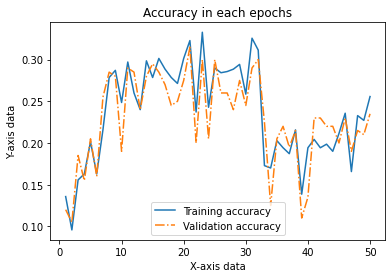

In [ ]:
model11 = classifier6(50,train_data_loader,val_data_loader)

Epoch [1/100]: 100%|██████████| 22/22 [00:08<00:00,  2.71it/s, loss=29.3]


Epoch 1,loss 29.3495, Accuracy 0.10428570955991745, ValAccuracy 0.08500000089406967


Epoch [2/100]: 100%|██████████| 22/22 [00:06<00:00,  3.31it/s, loss=1.89]


Epoch 2,loss 1.8947, Accuracy 0.11571428179740906, ValAccuracy 0.0949999988079071


Epoch [3/100]: 100%|██████████| 22/22 [00:06<00:00,  3.46it/s, loss=1.81]


Epoch 3,loss 1.8064, Accuracy 0.19428570568561554, ValAccuracy 0.1850000023841858


Epoch [4/100]: 100%|██████████| 22/22 [00:06<00:00,  3.42it/s, loss=1.8]


Epoch 4,loss 1.8018, Accuracy 0.3028571307659149, ValAccuracy 0.3050000071525574


Epoch [5/100]: 100%|██████████| 22/22 [00:06<00:00,  3.55it/s, loss=1.78]


Epoch 5,loss 1.7798, Accuracy 0.33142855763435364, ValAccuracy 0.3199999928474426


Epoch [6/100]: 100%|██████████| 22/22 [00:06<00:00,  3.57it/s, loss=1.72]


Epoch 6,loss 1.7169, Accuracy 0.34285715222358704, ValAccuracy 0.3050000071525574


Epoch [7/100]: 100%|██████████| 22/22 [00:06<00:00,  3.60it/s, loss=1.66]


Epoch 7,loss 1.6638, Accuracy 0.322857141494751, ValAccuracy 0.2750000059604645


Epoch [8/100]: 100%|██████████| 22/22 [00:06<00:00,  3.56it/s, loss=1.69]


Epoch 8,loss 1.6922, Accuracy 0.3257142901420593, ValAccuracy 0.3199999928474426


Epoch [9/100]: 100%|██████████| 22/22 [00:06<00:00,  3.52it/s, loss=1.63]


Epoch 9,loss 1.6281, Accuracy 0.3642857074737549, ValAccuracy 0.3499999940395355


Epoch [10/100]: 100%|██████████| 22/22 [00:06<00:00,  3.23it/s, loss=1.6]


Epoch 10,loss 1.6041, Accuracy 0.4042856991291046, ValAccuracy 0.3449999988079071


Epoch [11/100]: 100%|██████████| 22/22 [00:06<00:00,  3.15it/s, loss=1.54]


Epoch 11,loss 1.5407, Accuracy 0.3585714101791382, ValAccuracy 0.3449999988079071


Epoch [12/100]: 100%|██████████| 22/22 [00:07<00:00,  2.99it/s, loss=1.72]


Epoch 12,loss 1.7193, Accuracy 0.3571428656578064, ValAccuracy 0.3700000047683716


Epoch [13/100]: 100%|██████████| 22/22 [00:07<00:00,  3.04it/s, loss=1.56]


Epoch 13,loss 1.5561, Accuracy 0.345714271068573, ValAccuracy 0.3499999940395355


Epoch [14/100]: 100%|██████████| 22/22 [00:06<00:00,  3.29it/s, loss=1.57]


Epoch 14,loss 1.5664, Accuracy 0.3199999928474426, ValAccuracy 0.32499998807907104


Epoch [15/100]: 100%|██████████| 22/22 [00:06<00:00,  3.52it/s, loss=1.67]


Epoch 15,loss 1.6722, Accuracy 0.35285714268684387, ValAccuracy 0.3349999785423279


Epoch [16/100]: 100%|██████████| 22/22 [00:06<00:00,  3.55it/s, loss=1.54]


Epoch 16,loss 1.5427, Accuracy 0.40285712480545044, ValAccuracy 0.35499998927116394


Epoch [17/100]: 100%|██████████| 22/22 [00:06<00:00,  3.58it/s, loss=1.55]


Epoch 17,loss 1.5470, Accuracy 0.27714285254478455, ValAccuracy 0.26999998092651367


Epoch [18/100]: 100%|██████████| 22/22 [00:06<00:00,  3.58it/s, loss=1.57]


Epoch 18,loss 1.5671, Accuracy 0.35428571701049805, ValAccuracy 0.2800000011920929


Epoch [19/100]: 100%|██████████| 22/22 [00:06<00:00,  3.51it/s, loss=1.46]


Epoch 19,loss 1.4600, Accuracy 0.40285712480545044, ValAccuracy 0.4099999964237213


Epoch [20/100]: 100%|██████████| 22/22 [00:06<00:00,  3.50it/s, loss=1.4]


Epoch 20,loss 1.3982, Accuracy 0.4099999964237213, ValAccuracy 0.35999998450279236


Epoch [21/100]: 100%|██████████| 22/22 [00:06<00:00,  3.58it/s, loss=1.35]


Epoch 21,loss 1.3522, Accuracy 0.4657142758369446, ValAccuracy 0.4050000011920929


Epoch [22/100]: 100%|██████████| 22/22 [00:06<00:00,  3.42it/s, loss=1.37]


Epoch 22,loss 1.3699, Accuracy 0.36714285612106323, ValAccuracy 0.2800000011920929


Epoch [23/100]: 100%|██████████| 22/22 [00:06<00:00,  3.18it/s, loss=1.45]


Epoch 23,loss 1.4488, Accuracy 0.4814285635948181, ValAccuracy 0.45499998331069946


Epoch [24/100]: 100%|██████████| 22/22 [00:07<00:00,  2.98it/s, loss=1.42]


Epoch 24,loss 1.4232, Accuracy 0.43142858147621155, ValAccuracy 0.3449999988079071


Epoch [25/100]: 100%|██████████| 22/22 [00:07<00:00,  2.99it/s, loss=1.8]


Epoch 25,loss 1.7952, Accuracy 0.4471428394317627, ValAccuracy 0.3499999940395355


Epoch [26/100]: 100%|██████████| 22/22 [00:06<00:00,  3.33it/s, loss=1.32]


Epoch 26,loss 1.3177, Accuracy 0.4585714340209961, ValAccuracy 0.429999977350235


Epoch [27/100]: 100%|██████████| 22/22 [00:06<00:00,  3.52it/s, loss=1.29]


Epoch 27,loss 1.2877, Accuracy 0.41285714507102966, ValAccuracy 0.3799999952316284


Epoch [28/100]: 100%|██████████| 22/22 [00:06<00:00,  3.53it/s, loss=1.22]


Epoch 28,loss 1.2243, Accuracy 0.44999998807907104, ValAccuracy 0.4099999964237213


Epoch [29/100]: 100%|██████████| 22/22 [00:06<00:00,  3.53it/s, loss=1.38]


Epoch 29,loss 1.3763, Accuracy 0.4057142734527588, ValAccuracy 0.3449999988079071


Epoch [30/100]: 100%|██████████| 22/22 [00:06<00:00,  3.46it/s, loss=1.25]


Epoch 30,loss 1.2544, Accuracy 0.5657142996788025, ValAccuracy 0.5299999713897705


Epoch [31/100]: 100%|██████████| 22/22 [00:06<00:00,  3.52it/s, loss=1.42]


Epoch 31,loss 1.4226, Accuracy 0.5357142686843872, ValAccuracy 0.4399999976158142


Epoch [32/100]: 100%|██████████| 22/22 [00:06<00:00,  3.58it/s, loss=1.22]


Epoch 32,loss 1.2204, Accuracy 0.4985714256763458, ValAccuracy 0.4099999964237213


Epoch [33/100]: 100%|██████████| 22/22 [00:06<00:00,  3.54it/s, loss=1.99]


Epoch 33,loss 1.9926, Accuracy 0.44428572058677673, ValAccuracy 0.3449999988079071


Epoch [34/100]: 100%|██████████| 22/22 [00:06<00:00,  3.48it/s, loss=1.2]


Epoch 34,loss 1.2009, Accuracy 0.5342857241630554, ValAccuracy 0.4699999988079071


Epoch [35/100]: 100%|██████████| 22/22 [00:06<00:00,  3.15it/s, loss=1.07]


Epoch 35,loss 1.0742, Accuracy 0.49000000953674316, ValAccuracy 0.4599999785423279


Epoch [36/100]: 100%|██████████| 22/22 [00:07<00:00,  3.06it/s, loss=1.11]


Epoch 36,loss 1.1061, Accuracy 0.47857141494750977, ValAccuracy 0.3999999761581421


Epoch [37/100]: 100%|██████████| 22/22 [00:07<00:00,  2.93it/s, loss=1.04]


Epoch 37,loss 1.0353, Accuracy 0.5928571224212646, ValAccuracy 0.5299999713897705


Epoch [38/100]: 100%|██████████| 22/22 [00:06<00:00,  3.33it/s, loss=1.16]


Epoch 38,loss 1.1581, Accuracy 0.5099999904632568, ValAccuracy 0.44999998807907104


Epoch [39/100]: 100%|██████████| 22/22 [00:06<00:00,  3.42it/s, loss=1.12]


Epoch 39,loss 1.1204, Accuracy 0.5985714197158813, ValAccuracy 0.4749999940395355


Epoch [40/100]: 100%|██████████| 22/22 [00:06<00:00,  3.49it/s, loss=0.98]


Epoch 40,loss 0.9801, Accuracy 0.5185714364051819, ValAccuracy 0.38999998569488525


Epoch [41/100]: 100%|██████████| 22/22 [00:06<00:00,  3.48it/s, loss=1.01]


Epoch 41,loss 1.0066, Accuracy 0.522857129573822, ValAccuracy 0.4599999785423279


Epoch [42/100]: 100%|██████████| 22/22 [00:06<00:00,  3.53it/s, loss=1.02]


Epoch 42,loss 1.0248, Accuracy 0.5014285445213318, ValAccuracy 0.45499998331069946


Epoch [43/100]: 100%|██████████| 22/22 [00:06<00:00,  3.58it/s, loss=2.21]


Epoch 43,loss 2.2148, Accuracy 0.4814285635948181, ValAccuracy 0.38499999046325684


Epoch [44/100]: 100%|██████████| 22/22 [00:06<00:00,  3.56it/s, loss=1.3]


Epoch 44,loss 1.2998, Accuracy 0.2971428632736206, ValAccuracy 0.2800000011920929


Epoch [45/100]: 100%|██████████| 22/22 [00:06<00:00,  3.56it/s, loss=0.986]


Epoch 45,loss 0.9858, Accuracy 0.6571428775787354, ValAccuracy 0.5199999809265137


Epoch [46/100]: 100%|██████████| 22/22 [00:06<00:00,  3.37it/s, loss=0.783]


Epoch 46,loss 0.7834, Accuracy 0.6671428680419922, ValAccuracy 0.5699999928474426


Epoch [47/100]: 100%|██████████| 22/22 [00:06<00:00,  3.23it/s, loss=0.807]


Epoch 47,loss 0.8074, Accuracy 0.31857141852378845, ValAccuracy 0.29999998211860657


Epoch [48/100]: 100%|██████████| 22/22 [00:07<00:00,  2.97it/s, loss=0.796]


Epoch 48,loss 0.7964, Accuracy 0.5885714292526245, ValAccuracy 0.45499998331069946


Epoch [49/100]: 100%|██████████| 22/22 [00:07<00:00,  3.10it/s, loss=0.938]


Epoch 49,loss 0.9384, Accuracy 0.47428572177886963, ValAccuracy 0.3999999761581421


Epoch [50/100]: 100%|██████████| 22/22 [00:07<00:00,  2.98it/s, loss=0.773]


Epoch 50,loss 0.7732, Accuracy 0.75, ValAccuracy 0.6200000047683716


Epoch [51/100]: 100%|██████████| 22/22 [00:07<00:00,  2.92it/s, loss=0.745]


Epoch 51,loss 0.7451, Accuracy 0.6342856884002686, ValAccuracy 0.5399999618530273


Epoch [52/100]: 100%|██████████| 22/22 [00:07<00:00,  3.07it/s, loss=11.2]


Epoch 52,loss 11.2373, Accuracy 0.30714285373687744, ValAccuracy 0.2800000011920929


Epoch [53/100]: 100%|██████████| 22/22 [00:06<00:00,  3.46it/s, loss=1.11]


Epoch 53,loss 1.1132, Accuracy 0.545714259147644, ValAccuracy 0.4650000035762787


Epoch [54/100]: 100%|██████████| 22/22 [00:06<00:00,  3.48it/s, loss=0.906]


Epoch 54,loss 0.9064, Accuracy 0.6414285898208618, ValAccuracy 0.5149999856948853


Epoch [55/100]: 100%|██████████| 22/22 [00:06<00:00,  3.40it/s, loss=0.818]


Epoch 55,loss 0.8182, Accuracy 0.7171428203582764, ValAccuracy 0.5600000023841858


Epoch [56/100]: 100%|██████████| 22/22 [00:06<00:00,  3.49it/s, loss=0.761]


Epoch 56,loss 0.7609, Accuracy 0.764285683631897, ValAccuracy 0.574999988079071


Epoch [57/100]: 100%|██████████| 22/22 [00:06<00:00,  3.53it/s, loss=0.723]


Epoch 57,loss 0.7225, Accuracy 0.7485713958740234, ValAccuracy 0.6049999594688416


Epoch [58/100]: 100%|██████████| 22/22 [00:06<00:00,  3.51it/s, loss=0.619]


Epoch 58,loss 0.6186, Accuracy 0.7899999618530273, ValAccuracy 0.5849999785423279


Epoch [59/100]: 100%|██████████| 22/22 [00:06<00:00,  3.53it/s, loss=0.583]


Epoch 59,loss 0.5828, Accuracy 0.7814285755157471, ValAccuracy 0.5849999785423279


Epoch [60/100]: 100%|██████████| 22/22 [00:06<00:00,  3.52it/s, loss=0.573]


Epoch 60,loss 0.5733, Accuracy 0.7142857313156128, ValAccuracy 0.5349999666213989


Epoch [61/100]: 100%|██████████| 22/22 [00:06<00:00,  3.56it/s, loss=0.645]


Epoch 61,loss 0.6446, Accuracy 0.7542856931686401, ValAccuracy 0.5299999713897705


Epoch [62/100]: 100%|██████████| 22/22 [00:06<00:00,  3.30it/s, loss=0.483]


Epoch 62,loss 0.4825, Accuracy 0.7628571391105652, ValAccuracy 0.5649999976158142


Epoch [63/100]: 100%|██████████| 22/22 [00:07<00:00,  3.09it/s, loss=0.642]


Epoch 63,loss 0.6420, Accuracy 0.5914285778999329, ValAccuracy 0.42499998211860657


Epoch [64/100]: 100%|██████████| 22/22 [00:07<00:00,  2.97it/s, loss=0.398]


Epoch 64,loss 0.3980, Accuracy 0.7757142782211304, ValAccuracy 0.574999988079071


Epoch [65/100]: 100%|██████████| 22/22 [00:07<00:00,  3.05it/s, loss=0.436]


Epoch 65,loss 0.4361, Accuracy 0.8242856860160828, ValAccuracy 0.5899999737739563


Epoch [66/100]: 100%|██████████| 22/22 [00:06<00:00,  3.32it/s, loss=0.359]


Epoch 66,loss 0.3593, Accuracy 0.7428571581840515, ValAccuracy 0.5099999904632568


Epoch [67/100]: 100%|██████████| 22/22 [00:06<00:00,  3.37it/s, loss=0.999]


Epoch 67,loss 0.9990, Accuracy 0.7114285826683044, ValAccuracy 0.5249999761581421


Epoch [68/100]: 100%|██████████| 22/22 [00:06<00:00,  3.45it/s, loss=0.42]


Epoch 68,loss 0.4197, Accuracy 0.8814285397529602, ValAccuracy 0.5600000023841858


Epoch [69/100]: 100%|██████████| 22/22 [00:06<00:00,  3.50it/s, loss=0.296]


Epoch 69,loss 0.2959, Accuracy 0.9099999666213989, ValAccuracy 0.5899999737739563


Epoch [70/100]: 100%|██████████| 22/22 [00:06<00:00,  3.56it/s, loss=0.292]


Epoch 70,loss 0.2920, Accuracy 0.8842856884002686, ValAccuracy 0.5849999785423279


Epoch [71/100]: 100%|██████████| 22/22 [00:06<00:00,  3.51it/s, loss=0.641]


Epoch 71,loss 0.6414, Accuracy 0.7757142782211304, ValAccuracy 0.5049999952316284


Epoch [72/100]: 100%|██████████| 22/22 [00:06<00:00,  3.52it/s, loss=0.262]


Epoch 72,loss 0.2622, Accuracy 0.9114285707473755, ValAccuracy 0.6349999904632568


Epoch [73/100]: 100%|██████████| 22/22 [00:06<00:00,  3.51it/s, loss=0.29]


Epoch 73,loss 0.2900, Accuracy 0.8414285778999329, ValAccuracy 0.5849999785423279


Epoch [74/100]: 100%|██████████| 22/22 [00:06<00:00,  3.50it/s, loss=0.277]


Epoch 74,loss 0.2770, Accuracy 0.8971428275108337, ValAccuracy 0.5600000023841858


Epoch [75/100]: 100%|██████████| 22/22 [00:06<00:00,  3.59it/s, loss=0.291]


Epoch 75,loss 0.2906, Accuracy 0.918571412563324, ValAccuracy 0.6100000143051147


Epoch [76/100]: 100%|██████████| 22/22 [00:06<00:00,  3.30it/s, loss=0.143]


Epoch 76,loss 0.1432, Accuracy 0.868571400642395, ValAccuracy 0.5399999618530273


Epoch [77/100]: 100%|██████████| 22/22 [00:07<00:00,  3.08it/s, loss=0.248]


Epoch 77,loss 0.2481, Accuracy 0.6871428489685059, ValAccuracy 0.4699999988079071


Epoch [78/100]: 100%|██████████| 22/22 [00:07<00:00,  2.95it/s, loss=0.268]


Epoch 78,loss 0.2676, Accuracy 0.8285714387893677, ValAccuracy 0.550000011920929


Epoch [79/100]: 100%|██████████| 22/22 [00:07<00:00,  3.14it/s, loss=0.155]


Epoch 79,loss 0.1549, Accuracy 0.9514285326004028, ValAccuracy 0.6150000095367432


Epoch [80/100]: 100%|██████████| 22/22 [00:06<00:00,  3.32it/s, loss=0.119]


Epoch 80,loss 0.1186, Accuracy 0.8528571128845215, ValAccuracy 0.5450000166893005


Epoch [81/100]: 100%|██████████| 22/22 [00:06<00:00,  3.46it/s, loss=0.191]


Epoch 81,loss 0.1911, Accuracy 0.9657142758369446, ValAccuracy 0.6299999952316284


Epoch [82/100]: 100%|██████████| 22/22 [00:06<00:00,  3.43it/s, loss=0.0988]


Epoch 82,loss 0.0988, Accuracy 0.9399999976158142, ValAccuracy 0.574999988079071


Epoch [83/100]: 100%|██████████| 22/22 [00:06<00:00,  3.49it/s, loss=0.0924]


Epoch 83,loss 0.0924, Accuracy 0.9657142758369446, ValAccuracy 0.6399999856948853


Epoch [84/100]: 100%|██████████| 22/22 [00:06<00:00,  3.54it/s, loss=2.16]


Epoch 84,loss 2.1572, Accuracy 0.6200000047683716, ValAccuracy 0.4899999797344208


Epoch [85/100]: 100%|██████████| 22/22 [00:06<00:00,  3.56it/s, loss=0.397]


Epoch 85,loss 0.3967, Accuracy 0.8928571343421936, ValAccuracy 0.550000011920929


Epoch [86/100]: 100%|██████████| 22/22 [00:06<00:00,  3.46it/s, loss=0.0924]


Epoch 86,loss 0.0924, Accuracy 0.9728571176528931, ValAccuracy 0.6150000095367432


Epoch [87/100]: 100%|██████████| 22/22 [00:06<00:00,  3.53it/s, loss=0.0989]


Epoch 87,loss 0.0989, Accuracy 0.9728571176528931, ValAccuracy 0.6049999594688416


Epoch [88/100]: 100%|██████████| 22/22 [00:06<00:00,  3.54it/s, loss=0.0715]


Epoch 88,loss 0.0715, Accuracy 0.9642857313156128, ValAccuracy 0.5799999833106995


Epoch [89/100]: 100%|██████████| 22/22 [00:06<00:00,  3.47it/s, loss=0.0648]


Epoch 89,loss 0.0648, Accuracy 0.9814285635948181, ValAccuracy 0.6100000143051147


Epoch [90/100]: 100%|██████████| 22/22 [00:06<00:00,  3.51it/s, loss=0.218]


Epoch 90,loss 0.2184, Accuracy 0.8257142901420593, ValAccuracy 0.574999988079071


Epoch [91/100]: 100%|██████████| 22/22 [00:06<00:00,  3.54it/s, loss=0.0827]


Epoch 91,loss 0.0827, Accuracy 0.9585714340209961, ValAccuracy 0.5899999737739563


Epoch [92/100]: 100%|██████████| 22/22 [00:06<00:00,  3.40it/s, loss=0.0564]


Epoch 92,loss 0.0564, Accuracy 0.9785714149475098, ValAccuracy 0.5899999737739563


Epoch [93/100]: 100%|██████████| 22/22 [00:06<00:00,  3.21it/s, loss=0.0466]


Epoch 93,loss 0.0466, Accuracy 0.9642857313156128, ValAccuracy 0.6349999904632568


Epoch [94/100]: 100%|██████████| 22/22 [00:07<00:00,  3.08it/s, loss=0.0764]


Epoch 94,loss 0.0764, Accuracy 0.977142870426178, ValAccuracy 0.5999999642372131


Epoch [95/100]: 100%|██████████| 22/22 [00:07<00:00,  2.92it/s, loss=0.0677]


Epoch 95,loss 0.0677, Accuracy 0.8885714411735535, ValAccuracy 0.5799999833106995


Epoch [96/100]: 100%|██████████| 22/22 [00:07<00:00,  2.95it/s, loss=0.617]


Epoch 96,loss 0.6167, Accuracy 0.9628571271896362, ValAccuracy 0.6049999594688416


Epoch [97/100]: 100%|██████████| 22/22 [00:06<00:00,  3.30it/s, loss=0.0763]


Epoch 97,loss 0.0763, Accuracy 0.977142870426178, ValAccuracy 0.6150000095367432


Epoch [98/100]: 100%|██████████| 22/22 [00:06<00:00,  3.49it/s, loss=0.0481]


Epoch 98,loss 0.0481, Accuracy 0.9828571081161499, ValAccuracy 0.6399999856948853


Epoch [99/100]: 100%|██████████| 22/22 [00:06<00:00,  3.50it/s, loss=0.0899]


Epoch 99,loss 0.0899, Accuracy 0.9528571367263794, ValAccuracy 0.6049999594688416


Epoch [100/100]: 100%|██████████| 22/22 [00:06<00:00,  3.54it/s, loss=0.0486]


Epoch 100,loss 0.0486, Accuracy 0.9885714054107666, ValAccuracy 0.6449999809265137


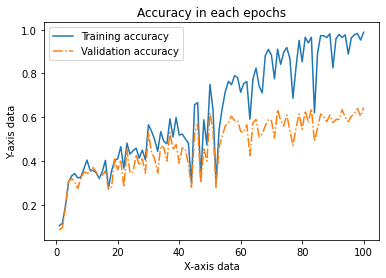

In [ ]:
model12 = classifier6(100,train_data_loader,val_data_loader)

In [ ]:
#Finding the performance on the test data


test_results_1 = get_accuracy(test_data_loader,model1,device)
test_results_2 = get_accuracy(test_data_loader,model2,device)
test_results_3 = get_accuracy(test_data_loader,model3,device)
test_results_4 = get_accuracy(test_data_loader,model4,device)
test_results_5 = get_accuracy(test_data_loader,model5,device)
test_results_6 = get_accuracy(test_data_loader,model6,device)
test_results_7 = get_accuracy(test_data_loader,model7,device)
test_results_8 = get_accuracy(test_data_loader,model8,device)
test_results_9 = get_accuracy(test_data_loader,model9,device)
test_results_10 = get_accuracy(test_data_loader,model10,device)
test_results_11 = get_accuracy(test_data_loader,model11,device)
test_results_12 = get_accuracy(test_data_loader,model12,device)

results = {
    "Model1": test_results_1,
    "Model2": test_results_2,
    "Model3": test_results_3,
    "Model4": test_results_4,
    "Model5": test_results_5,
    "Model6": test_results_6,
    "Model7": test_results_7,
    "Model8": test_results_8,
    "Model9": test_results_9,
    "Model10": test_results_10,
    "Model11": test_results_11,
    "Model12": test_results_12
}

In [ ]:
print(results)

{'Model1': 0.46464645862579346, 'Model2': 0.4343434274196625, 'Model3': 0.08080808073282242, 'Model4': 0.08080808073282242, 'Model5': 0.6868686676025391, 'Model6': 0.6666666865348816, 'Model7': 0.08080808073282242, 'Model8': 0.08080808073282242, 'Model9': 0.08080808073282242, 'Model10': 0.08080808073282242, 'Model11': 0.16161616146564484, 'Model12': 0.5353535413742065}
